In [1]:
# Load and install all packages as required
import geopandas as gpd
import rasterio
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from datetime import datetime
import os
import pickle
import seaborn as sns
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterio.transform import rowcol
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import log10
from openpyxl import load_workbook
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error
from scipy.stats import linregress
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_error as mae
from plotnine import *

SECTION 1

1)THESE PARTS IN HPC (the next cell)--i.e preliminary big data organization performed using high computing power.
Data prepared from in HPC is loaded and used for the main analysis here
To streamline our analysis we used Data6 which is the summary of all the big data processing, 
hence should be able to run in any computer

In [2]:
# No need to load the data here, run cell and proceed to the next cell
if False:
    # Get the raw data
    full_preds = pd.read_pickle("Required data/full preds v7.pkl")
    # 2) Add Temperature
    Temp.to_pickle("Required data/full preds v7/Temp.pkl")
    # 3) Add the state where the point comes from
    Data2.to_pickle("Required data/full preds v7/Data2.pkl")
    # 4) Convert Data2 (m2) into data frame
    EF3.to_pickle("Required data/full preds v7/Data3.pkl")
    # 5) Convert Temp (C) into data frame
    TotCH4.to_pickle("Required data/full preds v7/Temp2.pkl")
    # 6) Calculate TotCH4 based on temp
    # 7) Filter farm dams because either too big or too small
    EF3.to_pickle("Required data/full preds v7/Data5.pkl")
    # 8) Summarise by States and Months
    Data6.to_pickle("Required data/full preds v7/Data6.pkl")

In [7]:
# Define the directory path
dir_path = "C:/Users/oodebiri/Desktop/Martino code conversion/Latest_conversion_version/OneDrive_2024-04-08/6.Updated to 2022"
# Change the current working directory
os.chdir(dir_path)
# Verify the change
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/nick/Documents/Work code/Weather-to-water


SECTION 2

In [4]:
# ------------------
# 2) ESTIMATE THE NUMBER OF FARM DAMS FROM 1990 TO 2030
# ------------------
# a) Load required files and data
Data6 = pd.read_csv('Required data/full preds v7/Data6.csv') #statistics on farm dam density from Weather-to-Water
AllCounts = pd.read_csv('Required data/other datasets/AllCounts.csv')# AllCounts: Number of farm dams from Remote Sensing article
print(Data6.head())
print(AllCounts.head())

                           NAME  FinYear        Date  SumArea.kha  \
0  Australian Capital Territory     1980  1980-01-01     0.077286   
1  Australian Capital Territory     1980  1980-02-01     0.123209   
2  Australian Capital Territory     1980  1980-03-01     0.078813   
3  Australian Capital Territory     1980  1980-04-01     0.034930   
4  Australian Capital Territory     1980  1980-05-01     0.062428   

   SumArea.kha_LCI  SumArea.kha_UCI        EF    EF_LCI    EF_UCI  \
0         0.042507         0.112065  0.266889  0.094544  0.780709   
1         0.067765         0.178654  0.280978  0.097011  0.843247   
2         0.043347         0.114278  0.251259  0.091737  0.713058   
3         0.019212         0.050649  0.192174  0.080230  0.476942   
4         0.034335         0.090521  0.157190  0.072562  0.352815   

   TotCH4.ktyear  TotCH4.ktyear_LCI  TotCH4.ktyear_UCI       Temp  Count  
0       0.020701           0.004026           0.087966  19.544703   1220  
1       0.034690    

In [5]:
# Total farm dams in Australia in 2021
total_farm_dams = AllCounts['Count.50'].sum()
print("Total farm dams in 2021:", total_farm_dams)

# Process AllCounts data
AllCounts2 = AllCounts[['State', 'Count.50', 'Count.2.5', 'Count.97.5']].rename(
    columns={
        'State': 'NAME',
        'Count.50': 'ObsCount.2021',
        'Count.2.5': 'ObsCount.2021.LCI',
        'Count.97.5': 'ObsCount.2021.UCI'
    }
)
print(AllCounts2)
# Save AllCounts2 data if necessary
# AllCounts2.to_csv("Required data/full preds v7/AllCounts2.csv", index=False)

# Display sums for checking
print("Sum ObsCount.2021:", AllCounts2['ObsCount.2021'].sum())
print("Sum ObsCount.2021.LCI:", AllCounts2['ObsCount.2021.LCI'].sum())
print("Sum ObsCount.2021.UCI:", AllCounts2['ObsCount.2021.UCI'].sum())

# Load the statistics on farm dam density from Weather-to-Water
# Group by NAME and summarize to compute adjustment coefficients
AllCounts3 = (
    Data6.groupby('NAME')
    .agg({'Count': 'first'})  
    .rename(columns={'Count': 'FD.count'})
    .reset_index()
    .merge(AllCounts2, on='NAME', how='outer')
    .dropna(subset=['FD.count'])
    .query("NAME not in ['Northern Territory', 'Other Territories']")
    .assign(
        # These are the adjustment coefficients to upscale Nick's data to cover all farm dams
        **{'AdjCoef': lambda x: x['ObsCount.2021'] / x['FD.count'],
        'AdjCoef.LCI': lambda x: x['ObsCount.2021.LCI'] / x['FD.count'],
        'AdjCoef.UCI': lambda x: x['ObsCount.2021.UCI'] / x['FD.count']}
    )
)

print(AllCounts3)
# Save
AllCounts3.to_csv("Required data/full preds v7/AllCounts3.csv", index=False)

Total farm dams in 2021: 1765152.0350809898
                           NAME  ObsCount.2021  ObsCount.2021.LCI  \
0  Australian Capital Territory    2143.638710        2035.527246   
1               New South Wales  654983.470043      648201.648689   
2            Northern Territory   15183.136747       11824.106404   
3                    Queensland  234895.954852      211718.083430   
4               South Australia  117001.785632      109899.675167   
5                      Tasmania   63418.241039       55877.758550   
6                      Victoria  439964.608340      409958.563757   
7             Western Australia  237561.199718      218803.560194   

   ObsCount.2021.UCI  
0        2247.168831  
1      663366.792831  
2       17723.562610  
3      315968.163807  
4      121687.800981  
5       70987.293127  
6      458836.974625  
7      256622.266969  
Sum ObsCount.2021: 1765152.0350809898
Sum ObsCount.2021.LCI: 1668318.9234365933
Sum ObsCount.2021.UCI: 1907440.0237805578
     

In [6]:
# Adjust counts in W-to-W to include AdjCoef (excluding NT for which we have only 1 dam)
# Select wanted specific columns
Data7 = AllCounts3[['NAME', 'AdjCoef', 'AdjCoef.LCI', 'AdjCoef.UCI', 'ObsCount.2021']]

# Merge with Data6
Data7 = pd.merge(Data7, Data6, on='NAME', how='outer')

# Filter out rows where 'NAME' is 'Northern Territory' or 'Other Territories'
Data7 = Data7[~Data7['NAME'].isin(["Northern Territory", "Other Territories"])]

# Drop rows with NA values
Data7.dropna(inplace=True)

# Display the first few rows of the DataFrame to verify
print(Data7.head())
Data7.shape

# Create adjusted coefficient columns
Data7['Count.AdjCoef'] = Data7['Count'] * Data7['AdjCoef']
Data7['Count.AdjCoef.LCI'] = Data7['Count'] * Data7['AdjCoef.LCI']
Data7['Count.AdjCoef.UCI'] = Data7['Count'] * Data7['AdjCoef.UCI']

Data7['SumArea.kha.AdjCoef'] = Data7['SumArea.kha'] * Data7['AdjCoef']
Data7['SumArea.kha_LCI.AdjCoef'] = Data7['SumArea.kha_LCI'] * Data7['AdjCoef.LCI']
Data7['SumArea.kha_UCI.AdjCoef'] = Data7['SumArea.kha_UCI'] * Data7['AdjCoef.UCI']

Data7['TotCH4.ktyear.AdjCoef'] = Data7['TotCH4.ktyear'] * Data7['AdjCoef']
Data7['TotCH4.ktyear_LCI.AdjCoef'] = Data7['TotCH4.ktyear_LCI'] * Data7['AdjCoef.LCI']
Data7['TotCH4.ktyear_UCI.AdjCoef'] = Data7['TotCH4.ktyear_UCI'] * Data7['AdjCoef.UCI']

# Save
Data7.to_csv("Required data/full preds v7/Data7.csv", index=False)

                           NAME   AdjCoef  AdjCoef.LCI  AdjCoef.UCI  \
0  Australian Capital Territory  1.757081     1.668465     1.841942   
1  Australian Capital Territory  1.757081     1.668465     1.841942   
2  Australian Capital Territory  1.757081     1.668465     1.841942   
3  Australian Capital Territory  1.757081     1.668465     1.841942   
4  Australian Capital Territory  1.757081     1.668465     1.841942   

   ObsCount.2021  FinYear        Date  SumArea.kha  SumArea.kha_LCI  \
0     2143.63871     1980  1980-01-01     0.077286         0.042507   
1     2143.63871     1980  1980-02-01     0.123209         0.067765   
2     2143.63871     1980  1980-03-01     0.078813         0.043347   
3     2143.63871     1980  1980-04-01     0.034930         0.019212   
4     2143.63871     1980  1980-05-01     0.062428         0.034335   

   SumArea.kha_UCI        EF    EF_LCI    EF_UCI  TotCH4.ktyear  \
0         0.112065  0.266889  0.094544  0.780709       0.020701   
1         0.

Total CH4 Adjusted Coefficient for 2021: 35.53233750477698
Total CH4 for 2021: 25.58012495668403
Total CH4 Adjusted Coefficient for 2022: 40.53997311221103


C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\1527257781.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


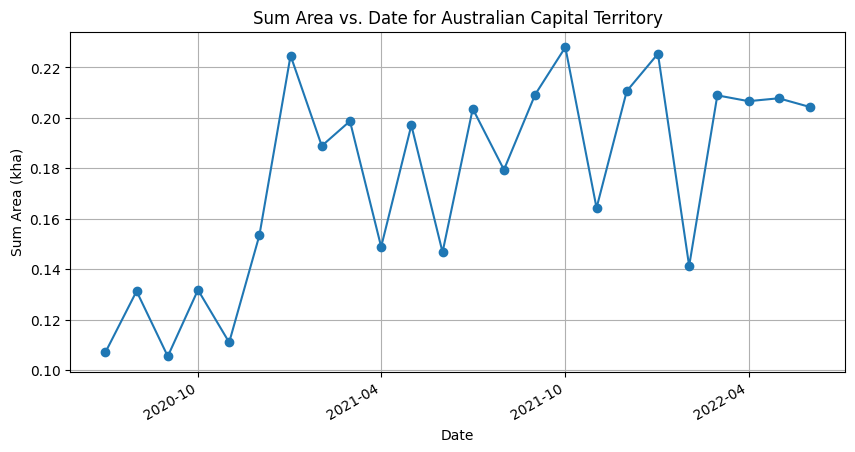

In [7]:
# Check ballpark values
# For Data7 in the year 2021
data7_2021 = Data7[Data7['FinYear'] == 2021]
grouped_2021 = data7_2021.groupby('NAME').agg(TotCH4_ktyear_AdjCoef=('TotCH4.ktyear.AdjCoef', 'mean'))
total_ch4_2021 = grouped_2021['TotCH4_ktyear_AdjCoef'].sum()
print("Total CH4 Adjusted Coefficient for 2021:", total_ch4_2021)

# For Data6 in the year 2021
data6_2021 = Data6[Data6['FinYear'] == 2021]
grouped_data6_2021 = data6_2021.groupby('NAME').agg(TotCH4_ktyear=('TotCH4.ktyear', 'mean'))
total_ch4_data6_2021 = grouped_data6_2021['TotCH4_ktyear'].sum()
print("Total CH4 for 2021:", total_ch4_data6_2021)

# For Data7 in the year 2022
data7_2022 = Data7[Data7['FinYear'] == 2022]
grouped_2022 = data7_2022.groupby('NAME').agg(TotCH4_ktyear_AdjCoef=('TotCH4.ktyear.AdjCoef', 'mean'))
total_ch4_2022 = grouped_2022['TotCH4_ktyear_AdjCoef'].sum()
print("Total CH4 Adjusted Coefficient for 2022:", total_ch4_2022)

# Test with a plot
# Plotting for Australian Capital Territory
test_plot = Data7[(Data7['NAME'] == "Australian Capital Territory") & (Data7['FinYear'].isin([2021, 2022]))]
test_plot['Date'] = pd.to_datetime(test_plot['Date']) # Ensure 'Date' is in datetime format
plt.figure(figsize=(10, 5))
plt.plot(test_plot['Date'], test_plot['SumArea.kha'], marker='o', linestyle='-')
plt.title('Sum Area vs. Date for Australian Capital Territory')
plt.xlabel('Date')
plt.ylabel('Sum Area (kha)')
plt.grid(True)
# Define the date format and interval
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
# Calculate NT Count and Percent Count 0.0086 or 0.86%
NT_Count = AllCounts.loc[AllCounts['State'] == "Northern Territory", 'Count.50'].sum()
Total_Count = AllCounts['Count.50'].sum()
NT_PercCount = NT_Count / Total_Count

# Calculate adjusted coefficients for Northern Territory
grouped = Data7.groupby(['Date', 'FinYear'])
aggregated = grouped.agg({
    'SumArea.kha.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'SumArea.kha_LCI.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'SumArea.kha_UCI.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'TotCH4.ktyear.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'TotCH4.ktyear_LCI.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'TotCH4.ktyear_UCI.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'Count.AdjCoef': lambda x: sum(x) * NT_PercCount,
    'Count.AdjCoef.LCI': lambda x: sum(x) * NT_PercCount,
    'Count.AdjCoef.UCI': lambda x: sum(x) * NT_PercCount
})

# Adding fixed values and additional columns
aggregated['NAME'] = "Northern Territory"
aggregated.reset_index(inplace=True)
additional_cols = ['AdjCoef', 'ObsCount.2021', 'SumArea.kha', 'SumArea.kha_LCI', 'SumArea.kha_UCI', 'TotCH4.ktyear',
                   'TotCH4.ktyear_LCI', 'TotCH4.ktyear_UCI', 'EF', 'EF_LCI', 'EF_UCI', 'Temp', 'Count',
                   'AdjCoef.LCI', 'AdjCoef.UCI']
for col in additional_cols:
    aggregated[col] = np.nan
aggregated['ObsCount.2021'] = NT_Count 

# Concatenate with original Data7 DataFrame
Data7_NT = pd.concat([Data7, aggregated])

#save the updated DataFrame
Data7_NT.to_csv("Required data/full preds v7/Data7_NT.csv", index=False)
Data7_NT.head()

,NAME,AdjCoef,AdjCoef.LCI,AdjCoef.UCI,ObsCount.2021,FinYear,Date,SumArea.kha,SumArea.kha_LCI,SumArea.kha_UCI,...,Count,Count.AdjCoef,Count.AdjCoef.LCI,Count.AdjCoef.UCI,SumArea.kha.AdjCoef,SumArea.kha_LCI.AdjCoef,SumArea.kha_UCI.AdjCoef,TotCH4.ktyear.AdjCoef,TotCH4.ktyear_LCI.AdjCoef,TotCH4.ktyear_UCI.AdjCoef
0,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,1980,1980-01-01,0.077286,0.042507,0.112065,...,1220.0,2143.63871,2035.527246,2247.168831,0.135798,0.070922,0.206417,0.036373,0.006717,0.162029
1,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,1980,1980-02-01,0.123209,0.067765,0.178654,...,1220.0,2143.63871,2035.527246,2247.168831,0.216489,0.113064,0.329069,0.060952,0.010980,0.278327
2,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,1980,1980-03-01,0.078813,0.043347,0.114278,...,1220.0,2143.63871,2035.527246,2247.168831,0.138480,0.072323,0.210494,0.034789,0.006634,0.150072
3,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,1980,1980-04-01,0.034930,0.019212,0.050649,...,1220.0,2143.63871,2035.527246,2247.168831,0.061375,0.032054,0.093292,0.011672,0.002558,0.043816
4,Australian Capital Territory,1.757081,1.668465,1.841942,2143.63871,1980,1980-05-01,0.062428,0.034335,0.090521,...,1220.0,2143.63871,2035.527246,2247.168831,0.109691,0.057287,0.166734,0.017199,0.004152,0.058610


In [9]:
# Load historical increase in farm dams from Remote Sensing article
# Python: Load the CSV file
HistData = pd.read_csv("Required data/Other datasets/Data6.kha.hist.csv")
# Filter the DataFrame
HistData = HistData[HistData['FinYear'].between(1990, 2021)]
# Select only the necessary columns
HistData = HistData[['State', 'FinYear', 'ecd']]
# Note: Historical increase for the NT calculated using ecd for Australia 

# Create a dataframe for the years 1990 to 2030 and merge with historical data
states = HistData['State'].unique()
fin_years = np.arange(1990, 2031)
HistData_exp = pd.DataFrame([(state, year) for state in states for year in fin_years], columns=['State', 'FinYear'])
# Merge the new DataFrame with the original one
HistData_exp = pd.merge(HistData_exp, HistData, on=['State', 'FinYear'], how='outer')

# Calculate future historical trends based on observations from 2005 and 2015
# Fit a linear model using a subset of the HisData_exp from 2006
HistData_exp_subset = HistData_exp[HistData_exp['FinYear'] > 2005]
HistData_lm = smf.ols(formula='ecd ~ FinYear*State', data=HistData_exp_subset).fit()
# Make predictions
HistData_exp['ecd.pred'] = HistData_lm.predict(HistData_exp)
# Select specific columns
HistData_exp = HistData_exp[['State', 'FinYear', 'ecd', 'ecd.pred']]
#check the first few columns which should now have the ecd_pred values
HistData_exp.head()

,State,FinYear,ecd,ecd.pred
0,Australian Capital Territory,1990,0.508197,0.630204
1,Australian Capital Territory,1991,0.516393,0.645604
2,Australian Capital Territory,1992,0.524590,0.661003
3,Australian Capital Territory,1993,0.590164,0.676403
4,Australian Capital Territory,1994,0.639344,0.691803


In [10]:
# If we have observations, keep that. Otherwise use ecd_pred
HistData_exp['ecd.comb'] = HistData_exp['ecd'].where(HistData_exp['ecd'].notna(), HistData_exp['ecd.pred'])

# Set the value for 2021 as 1 in each State
HistData_adj = HistData_exp.copy()
# Group by State and calculate ecd.adj
HistData_adj['ecd.adj'] = HistData_adj.groupby('State').apply(lambda x: x['ecd.comb'] / x.loc[x['FinYear'] == 2021, 'ecd.comb'].values[0]).reset_index(level=0, drop=True)
# Convert FinYear to categorical
HistData_adj['FinYear'] = HistData_adj['FinYear'].astype('category')
# Rename State to NAME
HistData_adj = HistData_adj.rename(columns={'State': 'NAME'})
# Select specific columns
HistData_adj = HistData_adj[['NAME', 'FinYear', 'ecd.adj']]

# Check. Works!
HistData_adj['FinYear'][HistData_adj['ecd.adj'] == 1]

C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\3506799258.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


31     2021
72     2021
113    2021
154    2021
195    2021
236    2021
277    2021
318    2021
Name: FinYear, dtype: category
Categories (41, int32): [1990, 1991, 1992, 1993, ..., 2027, 2028, 2029, 2030]

In [11]:
# Merge with rest of data
Data8 = pd.merge(Data7_NT, HistData_adj, on=['NAME', 'FinYear'])

# Create new columns
Data8['SumArea.kha.AdjCoef.ecd'] = Data8['SumArea.kha.AdjCoef'] * Data8['ecd.adj']
Data8['SumArea.kha_LCI.AdjCoef.ecd'] = Data8['SumArea.kha_LCI.AdjCoef'] * Data8['ecd.adj']
Data8['SumArea.kha_UCI.AdjCoef.ecd'] = Data8['SumArea.kha_UCI.AdjCoef'] * Data8['ecd.adj']

Data8['TotCH4.ktyear.AdjCoef.ecd'] = Data8['TotCH4.ktyear.AdjCoef'] * Data8['ecd.adj']
Data8['TotCH4.ktyear_LCI.AdjCoef.ecd'] = Data8['TotCH4.ktyear_LCI.AdjCoef'] * Data8['ecd.adj']
Data8['TotCH4.ktyear_UCI.AdjCoef.ecd'] = Data8['TotCH4.ktyear_UCI.AdjCoef'] * Data8['ecd.adj']

Data8['Count.AdjCoef.ecd'] = Data8['Count.AdjCoef'] * Data8['ecd.adj']
Data8['Count.AdjCoef.LCI.ecd'] = Data8['Count.AdjCoef.LCI'] * Data8['ecd.adj']
Data8['Count.AdjCoef.UCI.ecd'] = Data8['Count.AdjCoef.UCI'] * Data8['ecd.adj']

#save
Data8.to_csv("Required data/full preds v7/Data8.csv", index=False)
# Check stats
Data8.loc[Data8['FinYear'] == 2021, 'Count.AdjCoef'].unique().sum()
#Data8.head()

1765021.4357689284

In [12]:
# Summarise by State-by-Year and by Year
# Group by 'FinYear' and 'NAME', and calculate the statistics
Data9 = Data8.groupby(['FinYear', 'NAME']).agg({
    'Count.AdjCoef.ecd': 'first',
    'Count.AdjCoef.LCI.ecd': 'first',
    'Count.AdjCoef.UCI.ecd': 'first',
    'SumArea.kha.AdjCoef': 'mean',
    'SumArea.kha_LCI.AdjCoef': 'mean',
    'SumArea.kha_UCI.AdjCoef': 'mean',
    'SumArea.kha.AdjCoef.ecd': 'mean',
    'SumArea.kha_LCI.AdjCoef.ecd': 'mean',
    'SumArea.kha_UCI.AdjCoef.ecd': 'mean',
    'TotCH4.ktyear.AdjCoef.ecd': 'mean',
    'TotCH4.ktyear_LCI.AdjCoef.ecd': 'mean',
    'TotCH4.ktyear_UCI.AdjCoef.ecd': 'mean',
    'EF': 'mean',
    'EF_LCI': 'mean',
    'EF_UCI': 'mean'
}).reset_index()

# Year
# Further group by 'FinYear' and calculate the statistics
Data10 = Data9.groupby('FinYear').agg({
    'Count.AdjCoef.ecd': 'sum',
    'Count.AdjCoef.LCI.ecd': 'sum',
    'Count.AdjCoef.UCI.ecd': 'sum',
    'SumArea.kha.AdjCoef': 'sum',
    'SumArea.kha_LCI.AdjCoef': 'sum',
    'SumArea.kha_UCI.AdjCoef': 'sum',
    'SumArea.kha.AdjCoef.ecd': 'sum',
    'SumArea.kha_LCI.AdjCoef.ecd': 'sum',
    'SumArea.kha_UCI.AdjCoef.ecd': 'sum',
    'TotCH4.ktyear.AdjCoef.ecd': 'sum',
    'TotCH4.ktyear_LCI.AdjCoef.ecd': 'sum',
    'TotCH4.ktyear_UCI.AdjCoef.ecd': 'sum'
}).reset_index()

# Estimate CH4 flux
Data10['FluxCH4.ktyear.AdjCoef.ecd'] = Data10['TotCH4.ktyear.AdjCoef.ecd'] / Data10['SumArea.kha.AdjCoef.ecd']
Data10['FluxCH4.ktyear_LCI.AdjCoef.ecd'] = Data10['TotCH4.ktyear_LCI.AdjCoef.ecd'] / Data10['SumArea.kha_UCI.AdjCoef.ecd']
Data10['FluxCH4.ktyear_UCI.AdjCoef.ecd'] = Data10['TotCH4.ktyear_UCI.AdjCoef.ecd'] / Data10['SumArea.kha_LCI.AdjCoef.ecd']

# Convert 'FinYear' to numeric and remove 2023 from dataset
Data10['FinYear'] = pd.to_numeric(Data10['FinYear'], errors='coerce')
Data10 = Data10[Data10['FinYear'] < 2023]

max_TotCH4 = Data10['TotCH4.ktyear.AdjCoef.ecd'].max()
max_SumArea = Data10['SumArea.kha.AdjCoef.ecd'].max()
print("Max TotCH4.ktyear.AdjCoef.ecd:", max_TotCH4)
print("Max SumArea.kha.AdjCoef.ecd:", max_SumArea)

# checks For Financial Year 2021 &2022
Data10_2021 = Data10[Data10['FinYear'] == 2021]
Data10_2022 = Data10[Data10['FinYear'] == 2022]
#print(Data10_2021)
#print(Data10_2022)

# Filter the data for 'FinYear' between 1990 and 2022
Data10 = Data10[(Data10['FinYear'] >= 1990) & (Data10['FinYear'] <= 2022)]

# Table with all statistics
# Define the RightFormat function
def RightFormat(Mean, LCI, UCI, Round = 0, Div = 1):
    return f"{round(Mean/Div, Round)} [{round(LCI/Div, Round)}; {round(UCI/Div, Round)}]"
  
# Apply the RightFormat function to format the results and select only the new columns
Data10_format = Data10.copy()
Data10_format = Data10_format.assign(
    Count_k = Data10.apply(lambda row: RightFormat(row['Count.AdjCoef.ecd'], row['Count.AdjCoef.LCI.ecd'], row['Count.AdjCoef.UCI.ecd'], Div = 1000), axis=1),
    SA_k = Data10.apply(lambda row: RightFormat(row['SumArea.kha.AdjCoef.ecd'], row['SumArea.kha_LCI.AdjCoef.ecd'], row['SumArea.kha_UCI.AdjCoef.ecd'], Round = 2), axis=1),
    TotE_T3 = Data10.apply(lambda row: RightFormat(row['TotCH4.ktyear.AdjCoef.ecd'], row['TotCH4.ktyear_LCI.AdjCoef.ecd'], row['TotCH4.ktyear_UCI.AdjCoef.ecd']), axis=1),
    Flux = Data10.apply(lambda row: RightFormat(row['FluxCH4.ktyear.AdjCoef.ecd'], row['FluxCH4.ktyear_LCI.AdjCoef.ecd'], row['FluxCH4.ktyear_UCI.AdjCoef.ecd'], Div = 0.001, Round = 0), axis=1)
)[['FinYear', 'Count_k', 'SA_k', 'TotE_T3', 'Flux']]

#Save the dataframes to csv files
Data9.to_csv('Required data/full preds v7/Data9.csv', index=False)
Data10.to_csv('Required data/full preds v7/Data10.csv', index=False)
Data10_format.to_csv('Required data/full preds v7/Data10_format.csv', index=False)
Data10_format.head()

Max TotCH4.ktyear.AdjCoef.ecd: 41.06331447308056
Max SumArea.kha.AdjCoef.ecd: 175.94553855244766


,FinYear,Count_k,SA_k,TotE_T3,Flux
0,1990,1228.0 [1164.0; 1317.0],114.63 [59.71; 181.84],26.0 [5.0; 119.0],227.0 [28.0; 1987.0]
1,1991,1259.0 [1194.0; 1351.0],104.88 [54.59; 166.78],25.0 [5.0; 114.0],235.0 [29.0; 2096.0]
2,1992,1296.0 [1229.0; 1390.0],102.23 [53.23; 161.87],23.0 [5.0; 107.0],229.0 [28.0; 2012.0]
3,1993,1327.0 [1259.0; 1424.0],127.08 [66.28; 200.19],29.0 [6.0; 134.0],231.0 [29.0; 2019.0]
4,1994,1349.0 [1280.0; 1448.0],125.54 [65.5; 198.59],29.0 [6.0; 131.0],229.0 [29.0; 1998.0]


SECTION 3

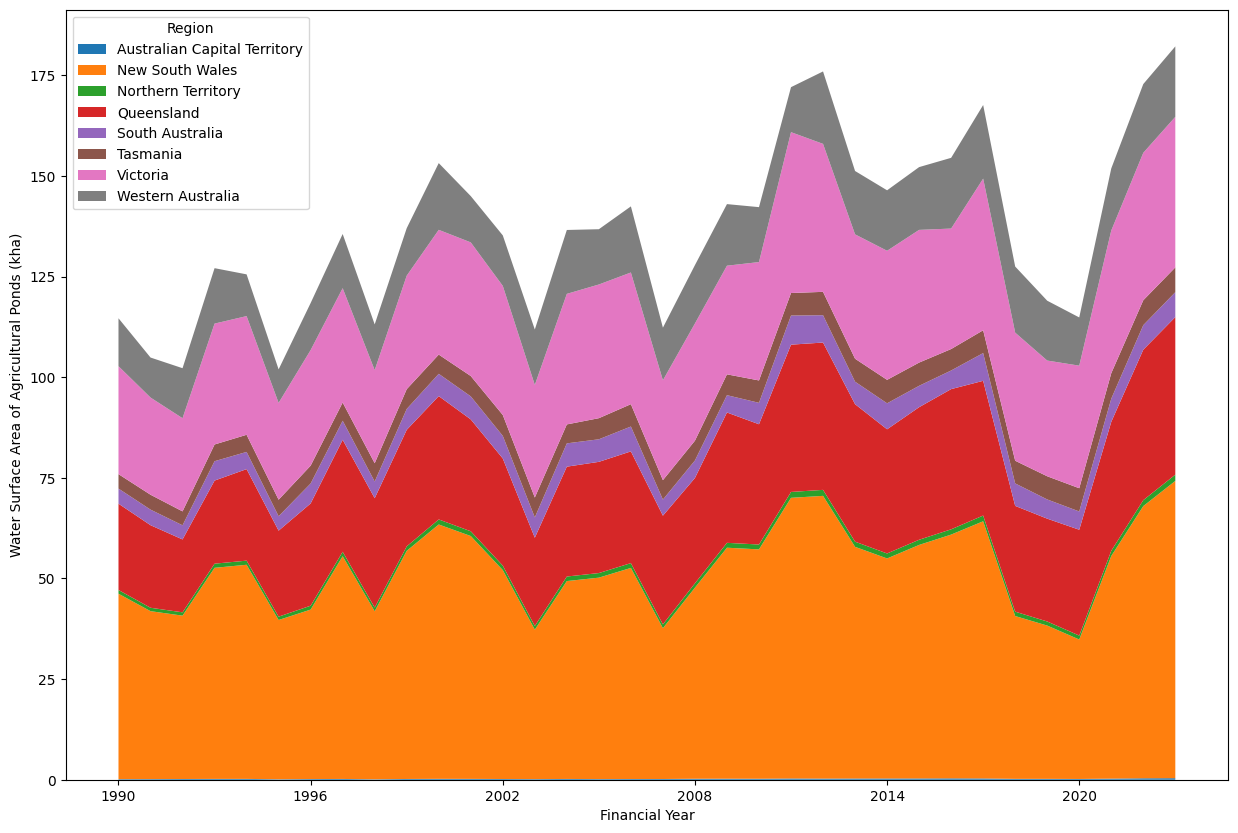

In [13]:
# ========
# FIGURE 3: Total water surface devided by State and Territories
# ========
# Create a list of unique years, stepping by 6
fin_year_breaks = Data9['FinYear'].unique()[::6]
# Pivot the data for stacked area plot
pivot_df = Data9.pivot(index='FinYear', columns='NAME', values='SumArea.kha.AdjCoef.ecd').fillna(0)
fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the size as needed
# Create the stacked area plot
ax.stackplot(pivot_df.index, pivot_df.T)
# Add labels and legend
ax.set_xlabel('Financial Year')
ax.set_ylabel('Water Surface Area of Agricultural Ponds (kha)')
ax.legend(pivot_df.columns, loc='upper left', title='Region')  # Add title to the legend
# Set xticks
ax.set_xticks(fin_year_breaks)
# Save the plot
plt.savefig("Plots/full preds v7/TotWaterSurface.pdf", format='pdf', dpi=300)
# Show the plot
plt.show()

In [14]:
# Stats
# Relative magnitude of year-to-year variability
SA_YearToYear_Rel = Data10['SumArea.kha.AdjCoef'].diff() / Data10['SumArea.kha.AdjCoef'].shift()
print("Mean of absolute relative year-to-year changes:", 100 * SA_YearToYear_Rel.abs().mean())
print("Max of absolute relative year-to-year changes:", 100 * SA_YearToYear_Rel.abs().max())

# Absolute difference
SA_YearToYear = Data10['SumArea.kha.AdjCoef'].diff()
print("Mean of absolute year-to-year changes:", SA_YearToYear.abs().mean())
print("Max of absolute year-to-year changes:", SA_YearToYear.abs().max())

Mean of absolute relative year-to-year changes: 11.460435831047254
Max of absolute relative year-to-year changes: 31.674195960867436
Mean of absolute year-to-year changes: 16.934213992480817
Max of absolute year-to-year changes: 41.180159220753325


SECTION 4

C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\2526176600.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


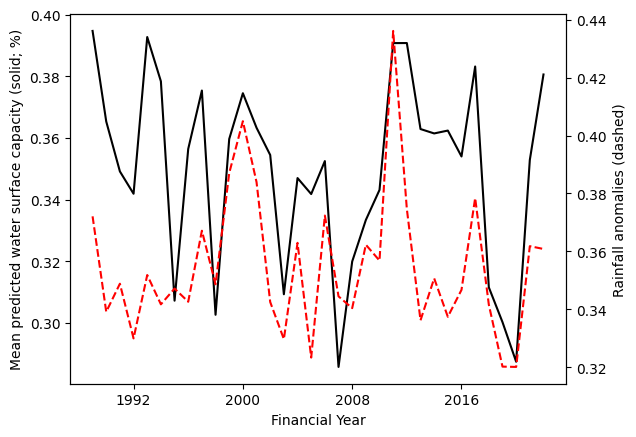

Pearson's correlation: r = 0.5719381524271262


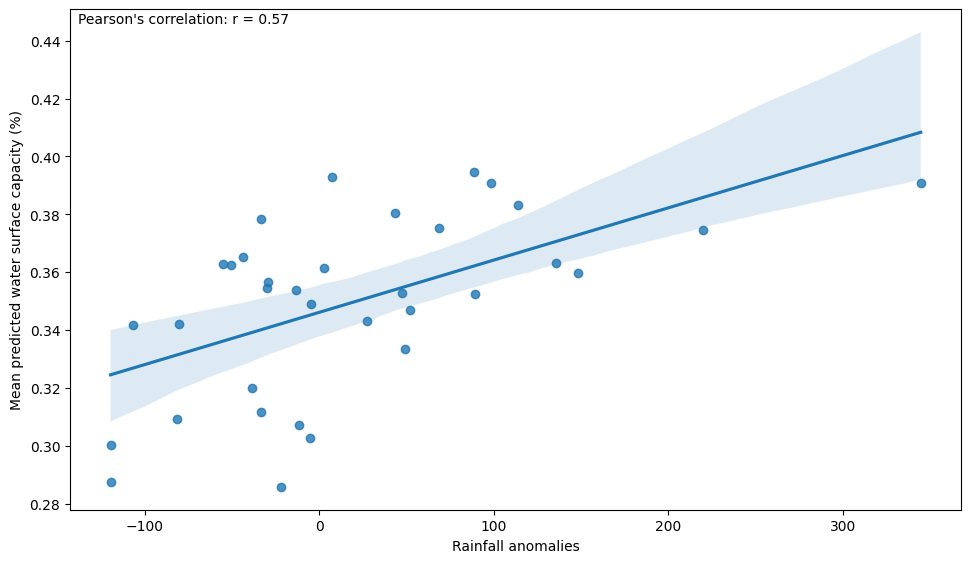

In [15]:
## =============
## FIGURE 4: COMPARE SURFACE AREA TO RAINFALL ANOMALIES FROM BOM
## =============
# (1) Load relative capacity
RelCapacity = pd.read_csv("Required data/full preds v7/RelCapacity.csv")
# (2) Load rainfall anomalies
# -----
# Website sourced: http://www.bom.gov.au/climate/change/#tabs=Tracker&tracker=timeseries&tQ=graph%3Drranom%26area%3Daus%26season%3D0706%26ave_yr%3D0
RainAnomalies = pd.read_csv("Required data/Other datasets/Rainfall anomalies.txt", 
                            delim_whitespace=True, 
                            names=["FinYear", "Anomaly"])

# Format the years by extracting the correct segment
RainAnomalies['FinYear'] = RainAnomalies['FinYear'].astype(str).str[6:10].astype(int)

# Subset for complete years (filtering the years to match specific range)
# i.e. those with 120 observations using table(Data6['FinYear'])
RainAnomalies_sub = RainAnomalies[(RainAnomalies['FinYear'] >= 1989) & (RainAnomalies['FinYear'] <= 2022)]

# New dataset with relative water capacity and BOM anomalies
RelCapacity['FinYear'] = RelCapacity['FinYear']
RelCapacity = RelCapacity.rename(columns={'NAME': 'State'})
RelCapacityBOM = RelCapacity.groupby(['FinYear', 'State']).agg({'RelSurfaceArea': 'mean'}).reset_index()

# Averaged across Aus
RelCapacity.rename(columns={'NAME': 'State'}, inplace=True)
RelCapacityBOM_aus = RelCapacity.groupby('FinYear', as_index=False).agg({'RelSurfaceArea':'mean'})
RelCapacityBOM_aus = pd.merge(RelCapacityBOM_aus, RainAnomalies_sub, on='FinYear', how='inner')

# Save the data
RelCapacityBOM.to_pickle("Required data/full preds v7/RelCapacityBOM.RData")
RelCapacityBOM_aus.to_pickle("Required data/full preds v7/RelCapacityBOM.aus.RData")

#RelCapacityBOM.head()
#RelCapacityBOM_aus.head()

# Lineplot of average relative capacity and BOM rainfall anomalies
fig, ax1 = plt.subplots()

# Plot the mean predicted water surface capacity on the first y-axis
ax1.plot(RelCapacityBOM_aus['FinYear'], RelCapacityBOM_aus['RelSurfaceArea'], color='black')
ax1.set_xlabel('Financial Year')
ax1.set_ylabel('Mean predicted water surface capacity (solid; %)')

# Create a second y-axis and plot the rainfall anomalies on it
ax2 = ax1.twinx()
ax2.plot(RelCapacityBOM_aus['FinYear'], (RelCapacityBOM_aus['Anomaly']/4000)+0.35, color='red', linestyle='dashed')
ax2.set_ylabel('Rainfall anomalies (dashed)')

# Set the number of ticks on the x-axis
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))

# Hide the grid lines
ax1.grid(False)
ax2.grid(False)

# Save the plot
plt.savefig("Plots/full preds v7/Predict.Plot.area.tot1.T4.pdf")

plt.show()

# Check correlation
correlation, _ = pearsonr(RelCapacityBOM_aus['RelSurfaceArea'], RelCapacityBOM_aus['Anomaly'])
print(f"Pearson's correlation: r = {correlation}")

# Scatterplot of average relative capacity and BOM rainfall anomalies
plt.figure(figsize=(11.5, 6.5))
sns.regplot(x='Anomaly', y='RelSurfaceArea', data=RelCapacityBOM_aus)
plt.xlabel('Rainfall anomalies')
plt.ylabel('Mean predicted water surface capacity (%)')
plt.grid(False)
plt.text(-138, 0.446, f"Pearson's correlation: r = {correlation:.2f}")

# Save the plot
plt.savefig("Plots/full preds v7/Predict.Plot.area.tot2.T4.pdf")

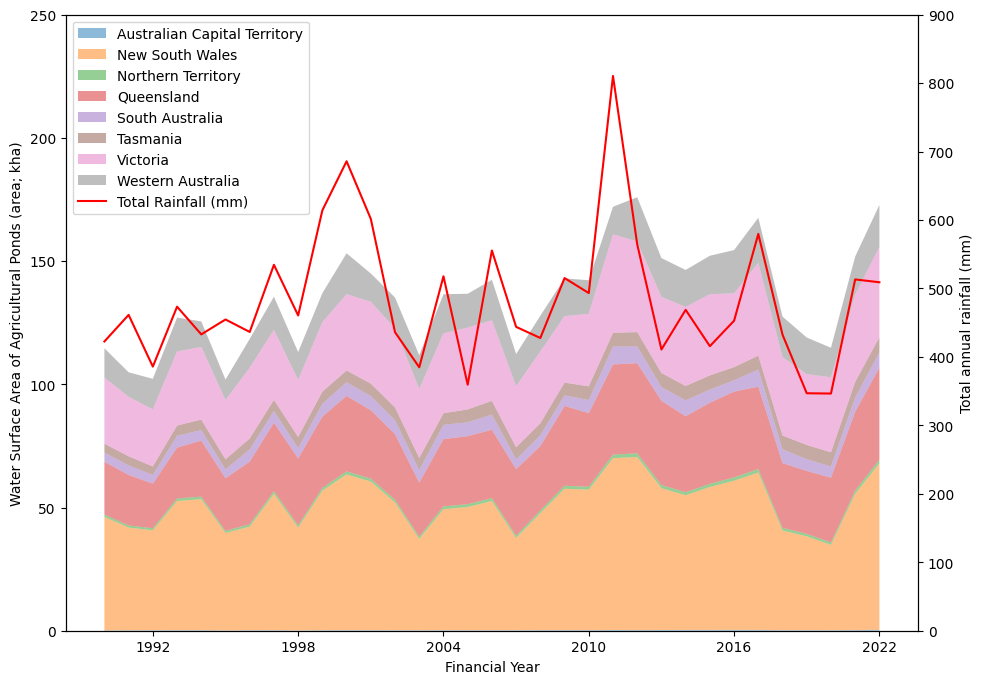

In [16]:
# ========
# Add total rainfall to the total water surface devided by State and Territories (Fig3)
# ========
  
# Get data on total rainfall
# Website sourced: http://www.bom.gov.au/climate/change/#tabs=Tracker&tracker=timeseries&tQ=graph%3Drranom%26area%3Daus%26season%3D0706%26ave_yr%3D0
# Load the datasets
TotalRain = pd.read_csv("Required data/Other datasets/Total rainfall.csv")
TotalRain.rename(columns={"Total Rainfall": "TotRain"}, inplace=True)  
TotalRain = TotalRain[(TotalRain['FinYear'] > 1989) & (TotalRain['FinYear'] < 2023)]

# We used Data 9 here. Load Data9 if not already loaded
Data9['FinYear'] = pd.to_numeric(Data9['FinYear'], errors='coerce')
Data9 = Data9[(Data9['FinYear'] > 1989) & (Data9['FinYear'] < 2023)]

# Plotting
fig, ax1 = plt.subplots(figsize=(11, 8)) 
# Get unique names
names = Data9['NAME'].unique()
# Create a list of data for each name
y = [Data9[Data9['NAME'] == name]['SumArea.kha.AdjCoef.ecd'].values for name in names]
# Stacked area plot for Water Surface Area
ax1.stackplot(Data9['FinYear'].unique(), y, labels=names, alpha=0.5)

# Line plot for Total Rainfall
ax2 = ax1.twinx()
ax2.plot(TotalRain['FinYear'], TotalRain['TotRain'], color='red', label='Total Rainfall (mm)')

# Setting labels
ax1.set_xlabel('Financial Year')
ax1.set_ylabel('Water Surface Area of Agricultural Ponds (area; kha)')
ax2.set_ylabel('Total annual rainfall (mm)')

# Set the limits of the primary and secondary y-axis 
ax1.set_ylim(0, 250)
ax2.set_ylim(0, 900)

# Customize ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
# Grid and legend
ax1.grid(False)
ax2.grid(False)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,
           loc='upper left', bbox_to_anchor=(0, 1))  
  
# Save and display the plot
plt.savefig("Plots/full preds v7/TotWaterSurfaceRain.pdf")
plt.show()

SECTION 5

C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\3224289077.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\3224289077.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\3224289077.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


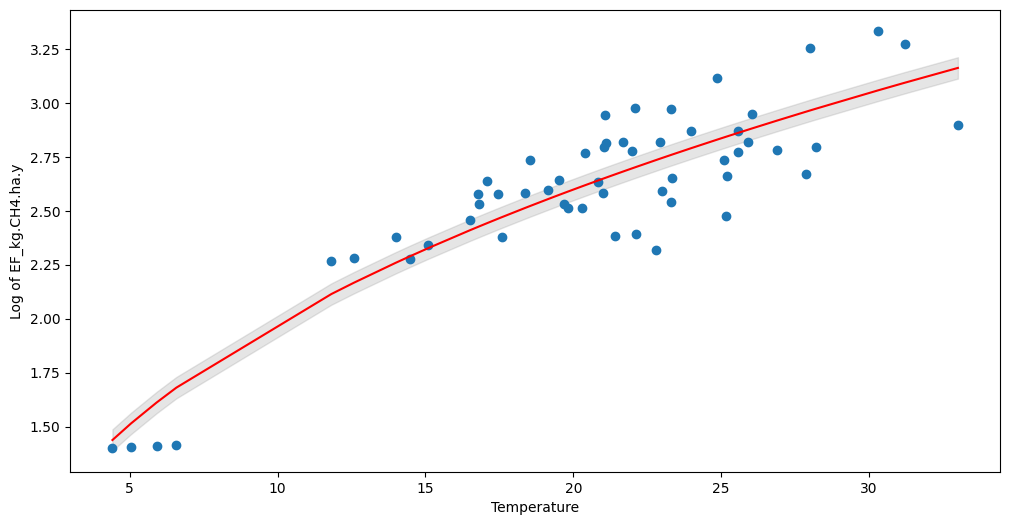

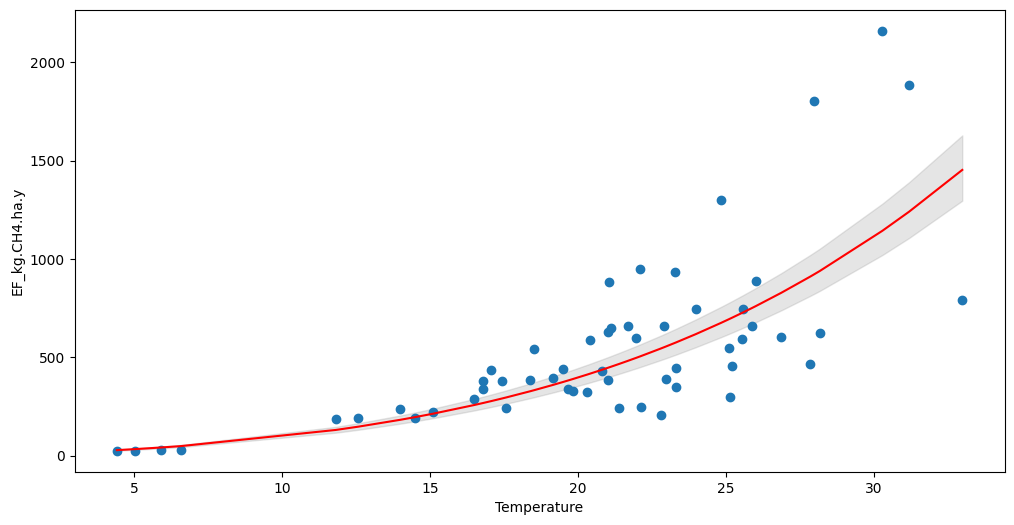

0     0.965525
1     0.967280
2     0.969237
3     0.970505
4     0.976559
5     0.977125
6     0.978064
7     0.978358
8     0.978705
9     0.979433
10    0.979573
11    0.979578
12    0.979710
13    0.979875
14    0.979938
15    0.980285
16    0.980344
17    0.980604
18    0.980737
19    0.980803
20    0.980864
21    0.981042
22    0.981075
23    0.981226
24    0.981292
25    0.981303
26    0.981310
27    0.981331
28    0.981427
29    0.981525
30    0.981621
31    0.981660
32    0.981670
33    0.981883
34    0.981923
35    0.981942
36    0.982036
37    0.982039
38    0.982042
39    0.982241
40    0.982484
41    0.982553
42    0.982567
43    0.982583
44    0.982677
45    0.982682
46    0.982764
47    0.982800
48    0.983015
49    0.983252
50    0.983285
51    0.983329
52    0.983795
53    0.983980
54    0.984328
dtype: float64
0     1.034475
1     1.032720
2     1.030763
3     1.029495
4     1.023441
5     1.022875
6     1.021936
7     1.021642
8     1.021295
9     1.020567
10    1.02

In [17]:
## =============
## FIGURE 5: COMPARE EMISSION FACTORS ACROSS TIERS
## =============
# X axis: temperature
# Y axis: emissions
# Colour: Tier 1, 2, and 3

# Create the dataset
TierComp = pd.DataFrame({'Temp': range(51)})

# Get temp-sensitivity (from Boltzmann.lm)
Boltzmann_lm_df = pd.DataFrame({'Fixef': [0.4287063], 'LCI': [0.2143579], 'UCI': [0.6430547]})

# Get the Boltzmann coefficient
Boltzmann_const_evK = 8.617333262145 * 1e-5

# Get Boltzmann factor across temps
TierComp['Boltzmann_15C'] = (1 / (Boltzmann_const_evK * (273.15 + 15))) - (1 / (Boltzmann_const_evK * (273.15 + TierComp['Temp'])))

# Load the average farm dam emissions at 15C in mg.m2.day (from TotMet_15C.lm)
TotMet_15C_lm_df = pd.DataFrame({'Fixef': [1.74705], 'LCI': [1.354771], 'UCI': [2.1546436]})

# Get average emission factor
FarmDams_CH4kgyearha_at15C = 365.25 * 10000 * (10 ** TotMet_15C_lm_df['Fixef'][0]) / 1e+6
FarmDams_CH4kgyearha_at15C_LCI = 365.25 * 10000 * (10 ** TotMet_15C_lm_df['LCI'][0]) / 1e+6
FarmDams_CH4kgyearha_at15C_UCI = 365.25 * 10000 * (10 ** TotMet_15C_lm_df['UCI'][0]) / 1e+6

# Get emissions T3 (kt.year.ha)
# ------
TierComp['EF_T3'] = np.exp(float(Boltzmann_lm_df['Fixef']) * TierComp['Boltzmann_15C'] + np.log(float(FarmDams_CH4kgyearha_at15C))) * 1000 / 1000000
TierComp['EF_T3_LCI'] = np.exp(float(Boltzmann_lm_df['LCI']) * TierComp['Boltzmann_15C'] + np.log(float(FarmDams_CH4kgyearha_at15C_LCI))) * 1000 / 1000000
TierComp['EF_T3_UCI'] = np.exp(float(Boltzmann_lm_df['UCI']) * TierComp['Boltzmann_15C'] + np.log(float(FarmDams_CH4kgyearha_at15C_UCI))) * 1000 / 1000000

# All in one equation
TierComp['EF_T3_AllInOne'] = np.exp(0.4287063 * ((1 / (8.617333e-05 * (273.15 + 15))) - (1 / (8.617333e-05 * (273.15 + TierComp['Temp'])))) + 5.318143) * 1000 / 1000000

# Get emissions T1 (kt.year.ha)
# ------
TierComp['EF_T1'] = 183 * 1000 / 1000000
TierComp['EF_T1_LCI'] = 118 * 1000 / 1000000
TierComp['EF_T1_UCI'] = 228 * 1000 / 1000000

# Get emissions T2, climate-specific EF following Tertius directions (Kg CH4 ha-1 year-1)
  # ------
# Load data
Tier2EF_dict = pd.read_excel("Required data/Other datasets/EF and climate zone dictionary.xlsx", sheet_name = "Restructure2")
Tier2EF_dict['EF_T2.kt'] = Tier2EF_dict['EF_T2']* 1000 /1000000
Tier2EF_dict['Climate'] = Tier2EF_dict['Climate'].astype('category')

# Merge data
TierComp2 = pd.merge(Tier2EF_dict, TierComp, on = "Temp", how = "outer")
# Extract the CI from the relationship
T2_raw = pd.read_excel("Required data/Other datasets/Farmdam EF values_COPY.xlsx", sheet_name = "Working data set_R")

# Define the model
def model(Temp, a, b):
    return a * Temp ** b

# Fit the model
popt, pcov = curve_fit(model, T2_raw['Temp'], np.log10(T2_raw['EF_kg.CH4.ha.y']), p0=[0.9, 2])
# Predict
T2_raw['pred'] = model(T2_raw['Temp'], *popt)

# Calculate prediction intervals
residuals = np.log10(T2_raw['EF_kg.CH4.ha.y'])- T2_raw['pred']
sse = np.sum(residuals**2)
mse = sse / (len(T2_raw) - len(popt))

# Calculate the prediction interval
t_value = stats.t.ppf(0.975, len(T2_raw) - len(popt))
pi = t_value * np.sqrt((1/len(T2_raw)) * mse)

# Add the prediction interval to the data frame
T2_raw['lower'] = T2_raw['pred'] - pi
T2_raw['upper'] = T2_raw['pred'] + pi

# Plot log-scale
plt.figure(figsize=(12, 6))
plt.plot(T2_raw['Temp'], T2_raw['pred'], 'r')
plt.fill_between(T2_raw['Temp'], T2_raw['lower'], T2_raw['upper'], color='gray', alpha=0.2)
plt.scatter(T2_raw['Temp'], np.log10(T2_raw['EF_kg.CH4.ha.y']))
plt.xlabel('Temperature')
plt.ylabel('Log of EF_kg.CH4.ha.y')
plt.show()

#plot arithmetic version
plt.figure(figsize=(12, 6))
plt.plot(T2_raw['Temp'], 10**T2_raw['pred'], 'r')
plt.fill_between(T2_raw['Temp'], 10**T2_raw['lower'], 10**T2_raw['upper'], color='gray', alpha=0.2)
plt.scatter(T2_raw['Temp'], T2_raw['EF_kg.CH4.ha.y'])
plt.xlabel('Temperature')
plt.ylabel('EF_kg.CH4.ha.y')
plt.show()
# Check for patterns
print(T2_raw['lower'] / T2_raw['pred'])
print(T2_raw['upper'] / T2_raw['pred'])
print(T2_raw['pred'] / T2_raw['upper'])
# Averages
print(np.mean(T2_raw['lower'] / T2_raw['pred']))
print(np.mean(T2_raw['upper'] / T2_raw['pred']))

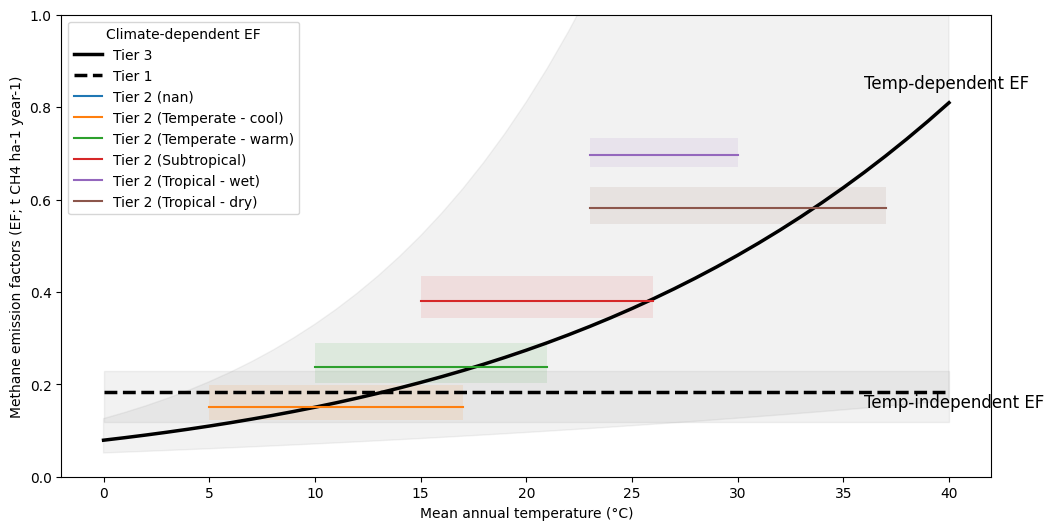

<Figure size 640x480 with 0 Axes>

In [18]:
# Solution:
# For the LCI, I will multiply the predicted log-10 value by 0.8432157 for R/But 0.9803596 for Python 
# For the UCI, I will multiply the predicted log-10 value by 1.100405 for R/But 1.0196403 for python
TierComp2['EF_T2.kt_UCI'] = 10**(np.log10(TierComp2['EF_T2.kt'])*0.8604673)
TierComp2['EF_T2.kt_LCI'] = 10**(np.log10(TierComp2['EF_T2.kt'])*1.1085)

# Filter data
TierComp2_filtered = TierComp2[TierComp2['Temp'] < 41]

# Plot
plt.figure(figsize=(12, 6))

# Calculate the mean of 'EF_T3', 'EF_T3_LCI', and 'EF_T3_UCI' for each temperature
Tier3_data = TierComp2_filtered.groupby('Temp').agg({'EF_T3':'mean', 'EF_T3_LCI':'mean', 'EF_T3_UCI':'mean'}).reset_index()

# Tier 3 ribbon and line
plt.fill_between(Tier3_data['Temp'], Tier3_data['EF_T3_LCI'], Tier3_data['EF_T3_UCI'], color='gray', alpha=0.1)
plt.plot(Tier3_data['Temp'], Tier3_data['EF_T3'], 'k', linewidth=2.5, label='Tier 3')

# Calculate the mean of 'EF_T1', 'EF_T1_LCI', and 'EF_T1_UCI' for each temperature
Tier1_data = TierComp2_filtered.groupby('Temp').agg({'EF_T1':'mean', 'EF_T1_LCI':'mean', 'EF_T1_UCI':'mean'}).reset_index()

# Tier 1 ribbon and line
plt.fill_between(Tier1_data['Temp'], Tier1_data['EF_T1_LCI'], Tier1_data['EF_T1_UCI'], color='gray', alpha=0.1)
plt.plot(Tier1_data['Temp'], Tier1_data['EF_T1'], 'k--', linewidth=2.5, label='Tier 1')

# Tier 2 ribbon and line for each climate
for climate in TierComp2_filtered['Climate'].unique():
    data = TierComp2_filtered[TierComp2_filtered['Climate'] == climate]
    plt.fill_between(data['Temp'], data['EF_T2.kt_LCI'], data['EF_T2.kt_UCI'], alpha=0.1)
    plt.plot(data['Temp'], data['EF_T2.kt'], linewidth=1.5, label=f'Tier 2 ({climate})')

plt.ylim(0, 1)
plt.xlabel('Mean annual temperature (°C)')
plt.ylabel('Methane emission factors (EF; t CH4 ha-1 year-1)')
plt.legend(title='Climate-dependent EF', loc='upper left')

plt.text(36, 0.84, 'Temp-dependent EF', fontsize=12)
plt.text(36, 0.15, 'Temp-independent EF', fontsize=12)

# Remove grid lines
plt.grid(False)

plt.show()

# Save plot
plt.savefig("Plots/full preds v7/Emission factors.pdf")
plt.savefig("Plots/full preds v7/Emission factors.jpeg")

# Save data
TierComp2.to_pickle("Required data/full preds v7/TierComp2.pkl")

SECTION 6

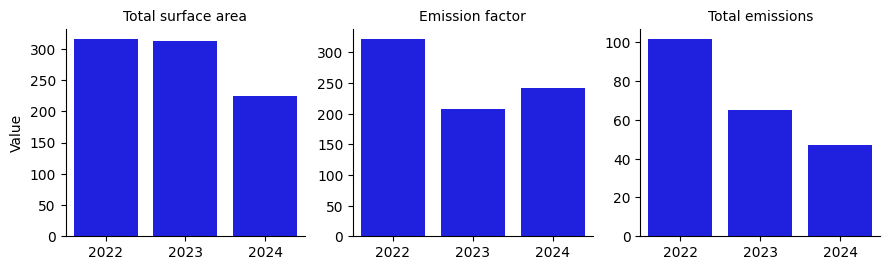

In [19]:
## =============
## FIGURE 6: Compare estimates from the NIR reports
## =============
# Load the data
NIRcomp = pd.read_excel("Required data/Other datasets/NIR comparison.xlsx")

# Ensure 'Variable' is a categorical variable with specific order
NIRcomp['Variable'] = pd.Categorical(NIRcomp['Variable'], categories=["Total surface area", "Emission factor", "Total emissions"], ordered=True)

# Plot
g = sns.FacetGrid(NIRcomp, col="Variable", col_order=["Total surface area", "Emission factor", "Total emissions"], sharey=False)
g.map_dataframe(sns.barplot, x="Year", y="Value", color='b')

# Remove grid lines and set background to white
g.set_axis_labels("", "Value")
g.set_titles("{col_name}")
g.fig.subplots_adjust(wspace=.2)

for ax in g.axes.flat:
    ax.grid(False)  # Turn off grid

plt.show()
# Save plot
g.savefig("Plots/full preds v7/NIRcomp.plot.pdf")

SECTION 7

MAE: 0.06046148857112542 ha
MAPE: 42.10239832444439%
Correlation: 0.7863693723086996


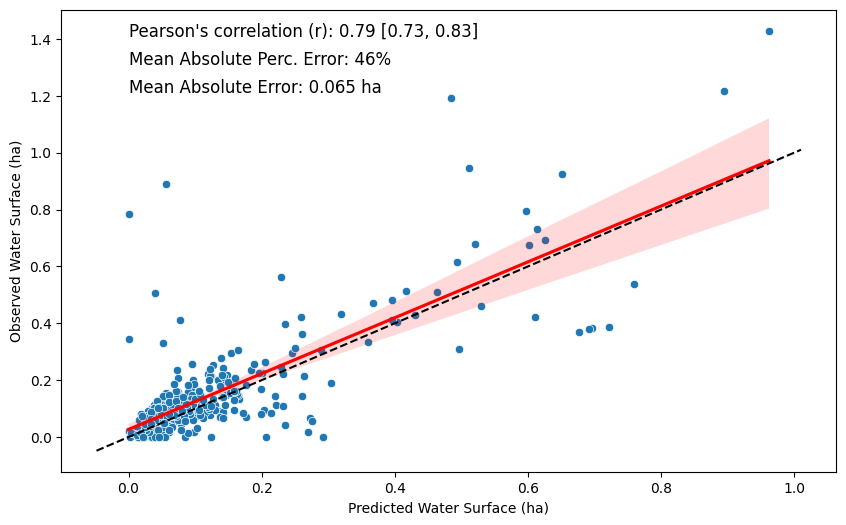

In [20]:
## =============
## FIGURE 7: Sources of uncertainty
## =============
# ------
# Average total methane emission at 15C
# ------
# Load the average farm dam emissions at 15C in mg.m2.day (from TotMet_15C.lm)
#We already did in section 5 when we compared emission factors accross Tiers but you can create it agian as done below
# Create the data frame
TotMet_15C_lm_df = pd.DataFrame({'Fixef': [1.74705], 'LCI': [1.354771], 'UCI': [2.1546436]})

# Convert from mg.m2.day to kg.ha.year
FarmDams_CH4kgyearha_at15C = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["Fixef"]) / 1e+6
FarmDams_CH4kgyearha_at15C_LCI = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["LCI"]) / 1e+6
FarmDams_CH4kgyearha_at15C_UCI = 365.25 * 10000 * (10 ** TotMet_15C_lm_df["UCI"]) / 1e+6

# CV for the relative error
Emissions_LCI = (FarmDams_CH4kgyearha_at15C - FarmDams_CH4kgyearha_at15C_LCI) / FarmDams_CH4kgyearha_at15C
Emissions_UCI = (FarmDams_CH4kgyearha_at15C_UCI - FarmDams_CH4kgyearha_at15C) / FarmDams_CH4kgyearha_at15C
Emissions_CV = np.mean([Emissions_LCI.values[0], Emissions_UCI.values[0]])

# -------
# Farm dam area (more details in "Download time series from Waterbodies" folder)
# -------
# Load the data
AllValidation = pd.read_csv("Required data/Other datasets/AllValidation.csv")

# MAE: Mean Absolute Error (ha)
MAE = mae(AllValidation['Obs'], AllValidation['Pred']) * 0.0001
print(f"MAE: {MAE} ha")  # 0.06ha

# MAPE: Mean Absolute Percent Error
MAPE = mae(AllValidation['Obs'], AllValidation['Pred']) / AllValidation['Obs'].mean() * 100
print(f"MAPE: {MAPE}%")  # 42%

# Correlation test
correlation, _ = stats.pearsonr(AllValidation['Obs'], AllValidation['Pred'])
print(f"Correlation: {correlation}")  # r = 0.79

# Calculate prediction intervals
# Fit the model
Val_lm = smf.ols(formula='Obs ~ Pred', data=AllValidation).fit()
# Predict the values
predictions = Val_lm.get_prediction(AllValidation)
predictions_summary_frame = predictions.summary_frame()
# Create a new DataFrame with the intervals
AllValidation_predint = pd.concat([AllValidation, predictions_summary_frame], axis=1)

#plot the data
# Create a new figure
plt.figure(figsize=(10, 6))

# Scatter plot of Observed vs Predicted Water Surface
sns.scatterplot(data=AllValidation_predint, x=AllValidation_predint['Pred']*0.0001, y=AllValidation_predint['Obs']*0.0001)

# Linear regression with confidence interval
sns.regplot(data=AllValidation_predint, x=AllValidation_predint['Pred']*0.0001, y=AllValidation_predint['Obs']*0.0001, color='red', scatter=False, ci=95, line_kws={'color':'red'})

# Add labels and remove grid
plt.xlabel('Predicted Water Surface (ha)')
plt.ylabel('Observed Water Surface (ha)')
plt.grid(False)

# Add annotations
plt.text(0*0.0001, 14100*0.0001, "Pearson's correlation (r): 0.79 [0.73, 0.83]", fontsize=12)
plt.text(0*0.0001, 13100*0.0001, "Mean Absolute Perc. Error: 46%", fontsize=12)
plt.text(0*0.0001, 12100*0.0001, "Mean Absolute Error: 0.065 ha", fontsize=12)

# Fit the 1:1 line to the data
x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
y = x
plt.plot(x, y, 'k--')

# Save the plot
plt.savefig("Plots/full preds v7/Validation weather-to-water_new.jpeg")
plt.savefig("Plots/full preds v7/Validation weather-to-water_new..pdf")
# Decide on a CV
FarmDamArea_CV = 0.42

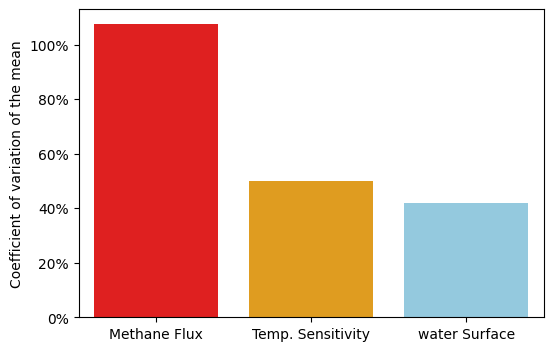

In [21]:
# -------
# Temp sensitivity
# -------
# Create DataFrame
Boltzmann_lm_df = pd.DataFrame({'Fixef': [0.4287063], 'LCI': [0.2143579], 'UCI': [0.6430547]})

# Calculate TempEmissions and CV
TempEmissions = {'mean': Boltzmann_lm_df.loc[0, 'Fixef'], 'LCI': Boltzmann_lm_df.loc[0, 'LCI'], 'UCI': Boltzmann_lm_df.loc[0, 'UCI']}
TempEmissions['CV_LCI'] = (TempEmissions['mean'] - TempEmissions['LCI']) / TempEmissions['mean']
TempEmissions['CV_UCI'] = (TempEmissions['UCI'] - TempEmissions['mean']) / TempEmissions['mean']
TempEmissions['CV'] = (TempEmissions['CV_UCI'] + TempEmissions['CV_LCI']) / 2

# All CVs
CV = {'Methane Flux': Emissions_CV, 'Temp. Sensitivity': TempEmissions['CV'],'water Surface': FarmDamArea_CV, }

# Create DataFrame
AllCV = pd.DataFrame(list(CV.items()), columns=['labels', 'CV'])
AllCV['CV_std'] = AllCV['CV'] / AllCV['CV'].sum()

# Save DataFrame
AllCV.to_pickle("Required data/full preds v7/AllCV.pkl")

# Define color palette
palette = ['red', 'orange', 'skyblue']

# Plot sources of uncertainty
plt.figure(figsize=(6, 4))
for i, label in enumerate(AllCV['labels']):
    sns.barplot(data=AllCV[AllCV['labels'] == label], x='labels', y='CV', color=palette[i])
plt.xlabel('')
plt.ylabel('Coefficient of variation of the mean')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.grid(False)

# Save plot
plt.savefig("Plots/full preds v7/CV.pdf")
plt.savefig("Plots/full preds v7/CV.jpeg")

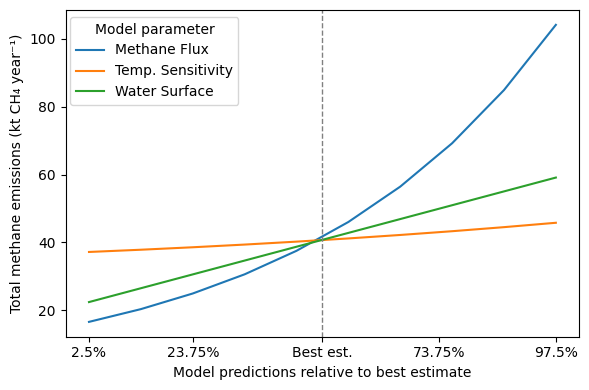

<Figure size 640x480 with 0 Axes>

In [22]:
## =============
## Spider plots
## =============
# Load the data from the sensitivity analysis
Data_loop2 = pd.read_excel("Required data/full preds v7/Data_loop2.xlsx", sheet_name="Reformat")

# Correct the column name to match Python's variable naming conventions (replace dots with underscores)
Data_loop2.columns = [col.replace('.', '_') for col in Data_loop2.columns]

# Create the Spider plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=Data_loop2, x='CI', y='TotCH4_ktyear_AdjCoef_ecd', hue='Par', errorbar=None)

# Customize the plot
plt.legend(title='Model parameter', bbox_to_anchor=(0.35, 1))
plt.grid(False)  # Turn off the grid
plt.xlabel('Model predictions relative to best estimate')
plt.ylabel('Total methane emissions (kt CH₄ year⁻¹)')
plt.xticks(ticks=[0.025, 0.2375, 0.5, 0.7375, 0.975], labels=["2.5%", "23.75%", "Best est.", "73.75%", "97.5%"])

# Optional: Add a vertical dashed line at the 'Best est.' mark
plt.axvline(x=0.5, color='gray', linestyle='dashed', linewidth=1)

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Save the plot
plt.savefig("Plots/full preds v7/Spider.jpeg")
plt.savefig("Plots/full preds v7/Spider.pdf")

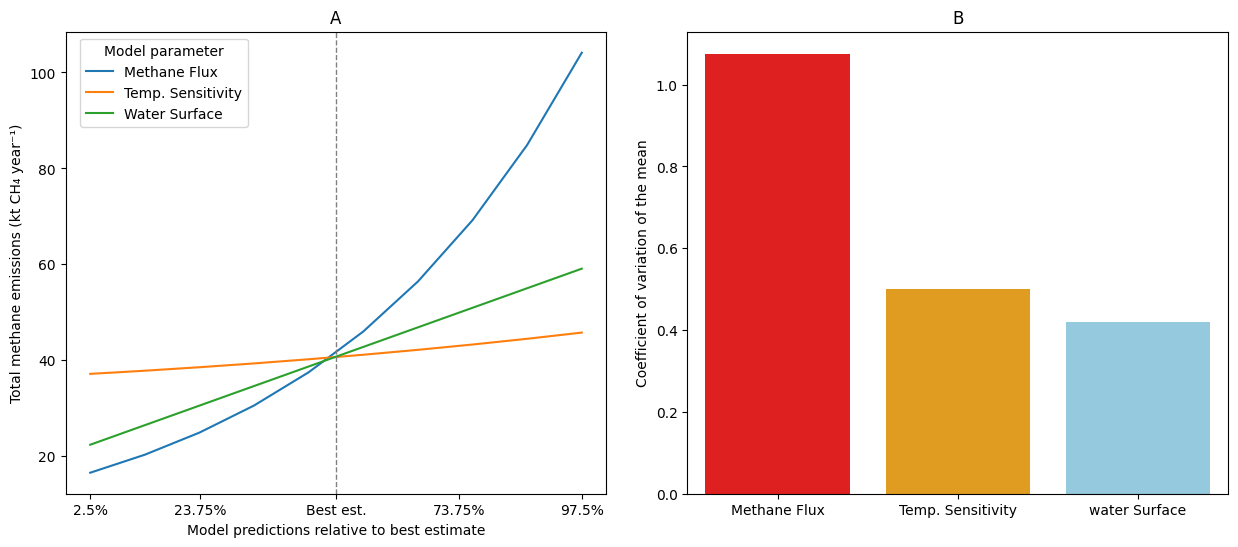

In [23]:
#Combine the plots and save it
def spider_plot(ax):
    Data_loop2.columns = [col.replace('.', '_') for col in Data_loop2.columns]
    sns.lineplot(data=Data_loop2, x='CI', y='TotCH4_ktyear_AdjCoef_ecd', hue='Par', ax=ax, errorbar=None)
    ax.set_xlabel('Model predictions relative to best estimate')
    ax.set_ylabel('Total methane emissions (kt CH₄ year⁻¹)')
    ax.legend(title='Model parameter', bbox_to_anchor=(0.35, 1))
    ax.grid(False)
    ax.axvline(x=0.5, color='gray', linestyle='dashed', linewidth=1)
    ax.set_xticks([0.025, 0.2375, 0.5, 0.7375, 0.975])
    ax.set_xticklabels(["2.5%", "23.75%", "Best est.", "73.75%", "97.5%"])

def cv_plot(ax):
    palette = ['red', 'orange', 'skyblue']
    for i, label in enumerate(AllCV['labels'].unique()):
        sns.barplot(data=AllCV[AllCV['labels'] == label], x='labels', y='CV', color=palette[i], ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Coefficient of variation of the mean')
    ax.grid(False)

# Create figure and axes
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2, figure=fig)
# Create Spider plot on the left
ax1 = fig.add_subplot(gs[0, 0])
spider_plot(ax1)
ax1.set_title('A')
# Create CV plot on the right
ax2 = fig.add_subplot(gs[0, 1])
cv_plot(ax2)
ax2.set_title('B')
# Adjust subplots
plt.subplots_adjust(wspace=0.15)
# Save the figure
plt.savefig("Plots/full preds v7/SpiderCV.pdf")
plt.savefig("Plots/full preds v7/SpiderCV.jpeg")
# Show the combined plots
plt.show()

SECTION 8

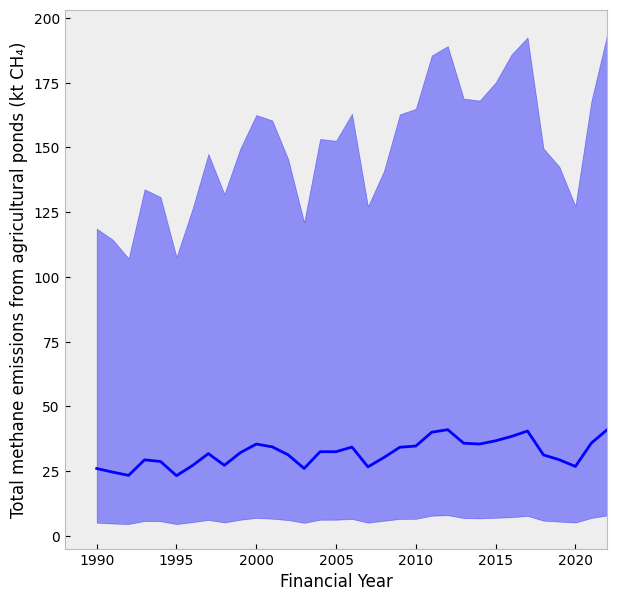

In [24]:
## =============
## FIGURE 8: Total methane emissions
## =============
# Set up the plot
plt.figure(figsize=(7, 7))
plt.style.use('bmh')  
# Plot the line for total methane emissions
sns.lineplot(data=Data10, x='FinYear', y='TotCH4.ktyear.AdjCoef.ecd', legend=False, color='b')

# Add a ribbon for confidence intervals
plt.fill_between(Data10['FinYear'], 
                 Data10['TotCH4.ktyear_LCI.AdjCoef.ecd'], 
                 Data10['TotCH4.ktyear_UCI.AdjCoef.ecd'], 
                 color='blue', alpha=0.4)

# Customizing the plot
plt.xlabel("Financial Year")
plt.ylabel("Total methane emissions from agricultural ponds (kt CH₄)")
plt.xlim(1988, 2022) 
plt.grid(False)  
#plt.title("Total Methane Emissions Visualization")  # Optional: add a title

# Save the plot
plt.savefig("Plots/full preds v7/TotEmissions_Aus.pdf")
plt.savefig("Plots/full preds v7/TotEmissions_Aus.jpeg")

# Show the plot
plt.show()

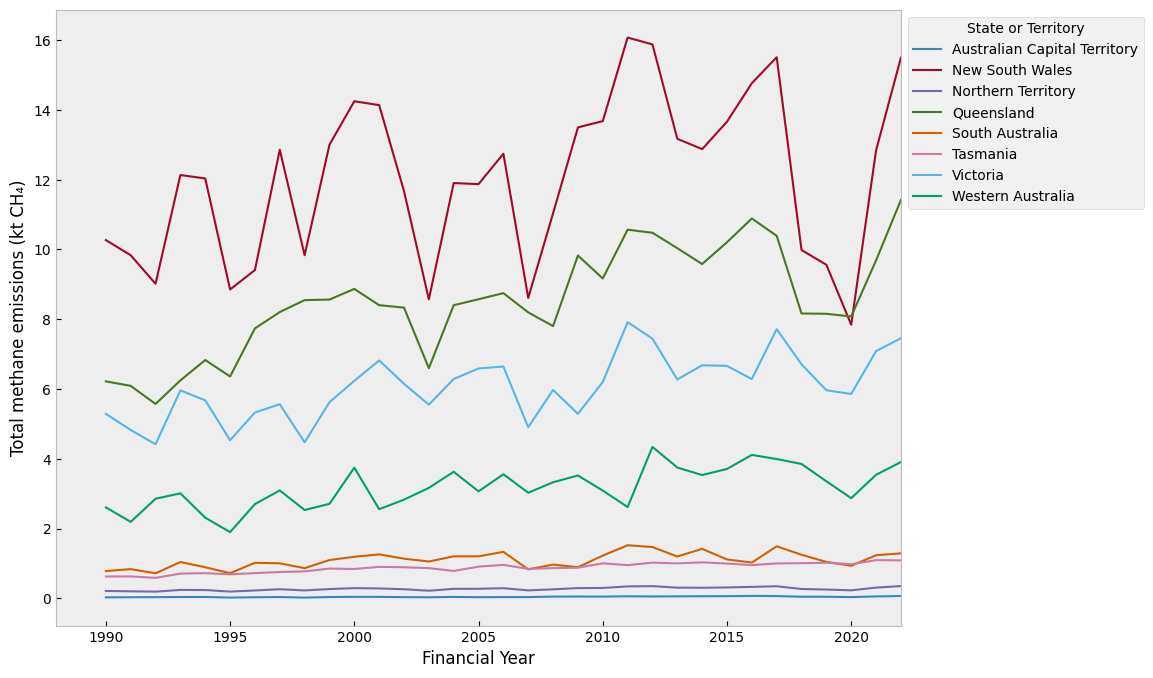

In [25]:
#plot On the same graph as different lines
# Set up the plot
plt.figure(figsize=(10.9, 8))  
plt.style.use('bmh')

# Plotting lines for each state or territory
sns.lineplot(data=Data9, x='FinYear', y='TotCH4.ktyear.AdjCoef.ecd', hue='NAME', linewidth=1.5)
# Customize the plot
plt.xlabel("Financial Year")
plt.ylabel("Total methane emissions (kt CH₄)")
plt.xlim(1988, 2022)  # Setting x-axis limits
plt.grid(False)  # Turning off the grid
plt.legend(title='State or Territory', loc='upper left', bbox_to_anchor=(1, 1))  
# Save the plot
plt.savefig("Plots/full preds v7/TotEmissions_State2.pdf", format='pdf')
plt.savefig("Plots/full preds v7/TotEmissions_State2.jpeg", format='jpeg')

# Show the plot
plt.show()

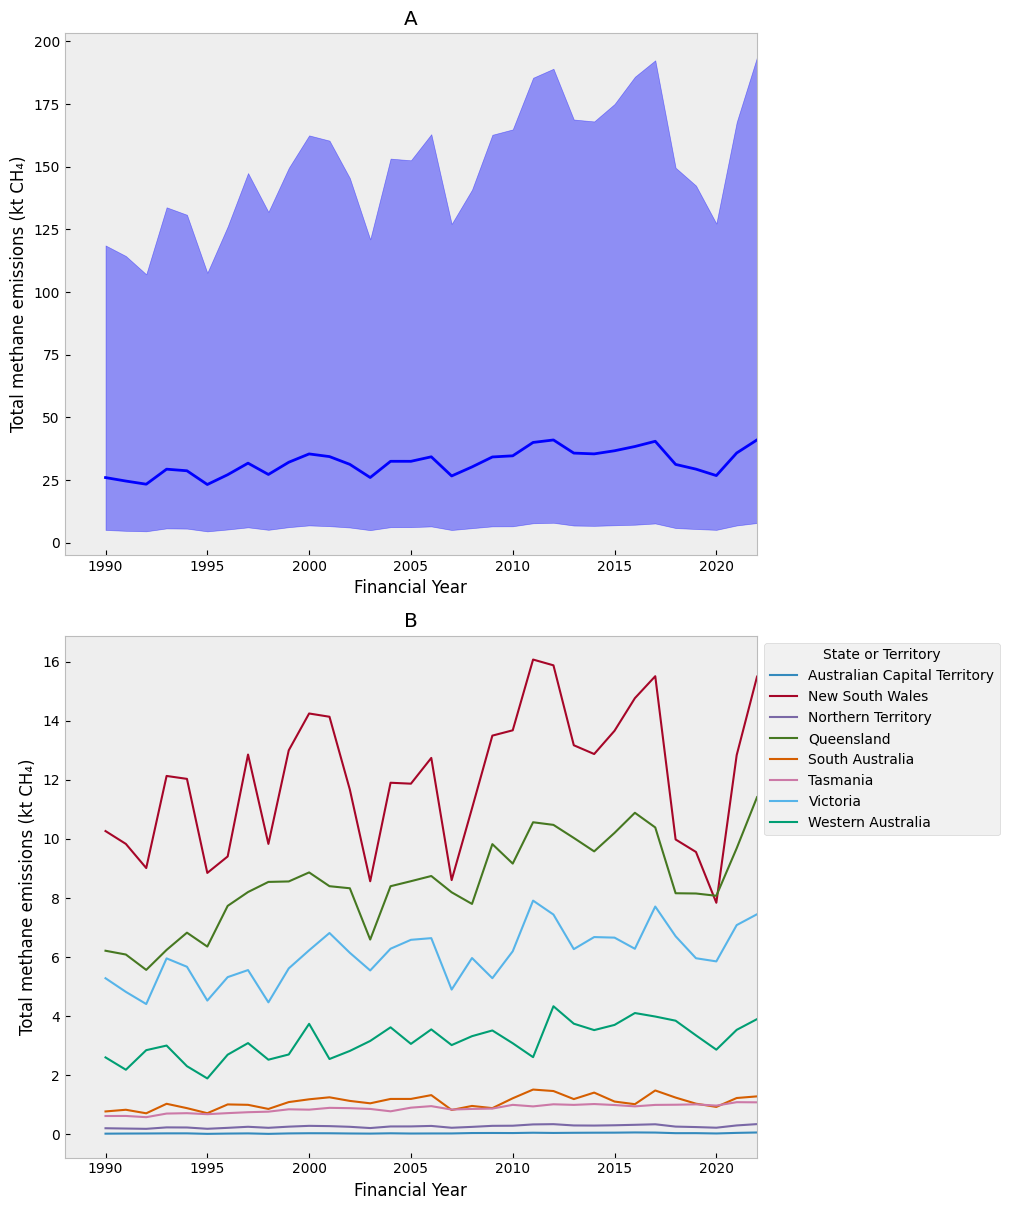

In [26]:
# Create figure with two subplots
fig = plt.figure(figsize=(10.2, 12.2))  # Width, Height in inches
gs = GridSpec(2, 1, figure=fig)

# First plot (Total methane emissions from agricultural ponds)
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(data=Data10, x='FinYear', y='TotCH4.ktyear.AdjCoef.ecd', legend=False, ax=ax1, color='b')
ax1.fill_between(Data10['FinYear'], Data10['TotCH4.ktyear_LCI.AdjCoef.ecd'], Data10['TotCH4.ktyear_UCI.AdjCoef.ecd'], color='blue', alpha=0.4)
ax1.set_xlabel("Financial Year")
ax1.set_ylabel("Total methane emissions (kt CH₄)")
ax1.set_xlim(1988, 2022)
plt.grid(False)
ax1.set_title("A")

# Second plot (State or territory-wise methane emissions)
ax2 = fig.add_subplot(gs[1, 0])
sns.lineplot(data=Data9, x='FinYear', y='TotCH4.ktyear.AdjCoef.ecd', hue='NAME', ax=ax2, linewidth=1.5)
ax2.set_xlabel("Financial Year")
ax2.set_ylabel("Total methane emissions (kt CH₄)")
ax2.set_xlim(1988, 2022)
plt.grid(False)
ax2.set_title("B")
ax2.legend(title='State or Territory', loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position

# Adjust layout
plt.tight_layout()

# Save the combined figure
plt.savefig("Plots/full preds v7/TotEmissions_both.pdf", format='pdf')
plt.savefig("Plots/full preds v7/TotEmissions_both.jpeg", format='jpeg')

# Display the figure
plt.show()

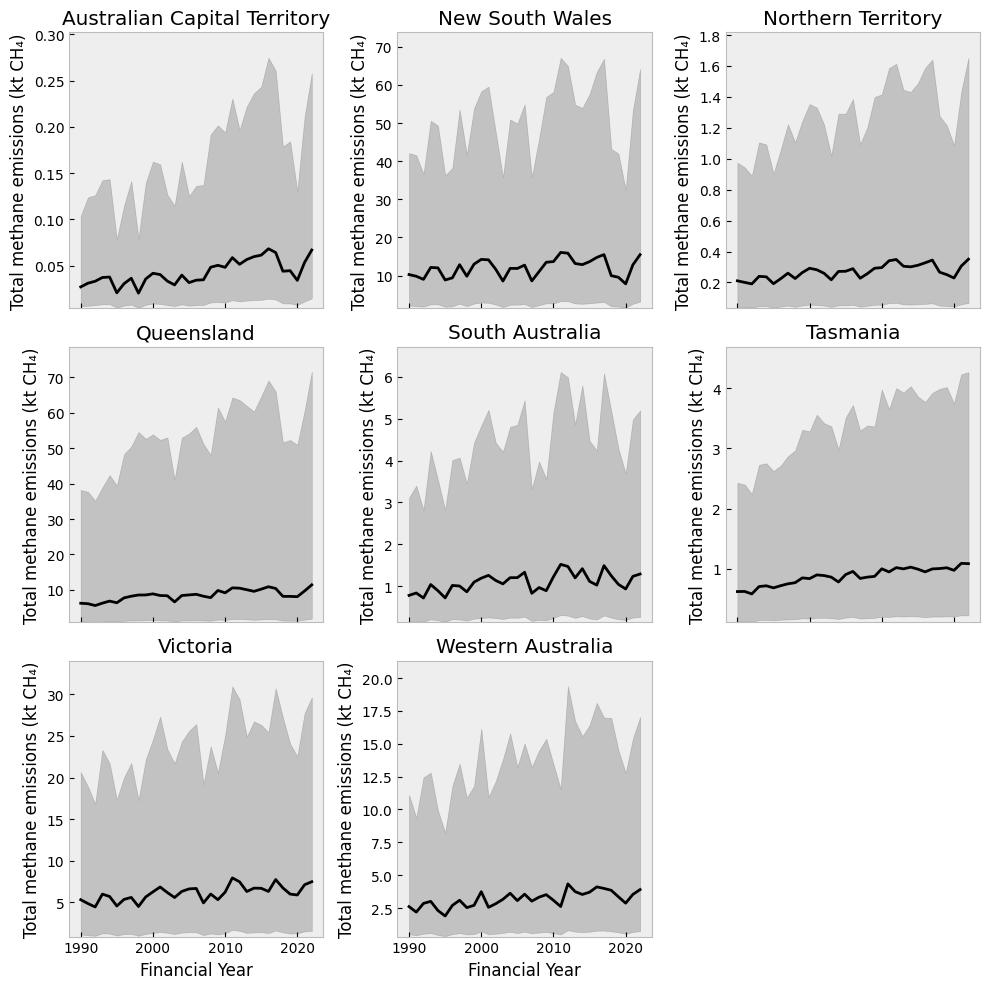

In [27]:
# Divided by States (TotEmissions)
# Determine the unique names and number of plots
unique_names = Data9['NAME'].unique()
n_cols = 3
n_rows = 3  # Or however many you need to fit all unique_names

# Set up the figure for the individual subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10), sharex=True)
axes = axes.flatten() # Flatten the 2D numpy array to 1D for easy iteration

# Loop through the names and axes to create each subplot
for ax, name in zip(axes, unique_names):
    # Filter the data for this specific name
    subset = Data9[Data9['NAME'] == name]    
    # Plot the line and fill for the subset
    sns.lineplot(ax=ax, data=subset, x='FinYear', y='TotCH4.ktyear.AdjCoef.ecd', color='black')
    ax.fill_between(subset['FinYear'], subset['TotCH4.ktyear_LCI.AdjCoef.ecd'], subset['TotCH4.ktyear_UCI.AdjCoef.ecd'], color='grey', alpha=0.4)   
    # Set the y-axis limits based on the subset data
    ymin = subset['TotCH4.ktyear_LCI.AdjCoef.ecd'].min() * 0.9
    ymax = subset['TotCH4.ktyear_UCI.AdjCoef.ecd'].max() * 1.1
    ax.set_ylim(ymin, ymax)   
    # Set the title for each subplot
    ax.set_title(name)
    ax.set_xlabel('Financial Year')
    ax.set_ylabel('Total methane emissions (kt CH₄)')    
    # Remove gridlines for each subplot
    ax.grid(False)

# Hide any unused subplots if you have fewer than 9 names
for i in range(len(unique_names), len(axes)):
    axes[i].set_visible(False)

# Adjust the layout
plt.tight_layout()
# Save the plot
fig.savefig("Plots/full preds v7/TotEmissions_State.pdf")
fig.savefig("Plots/full preds v7/TotEmissions_State.jpeg")
# Show the plot
plt.show()

In [28]:
## =============
## FIGURE 8: Test Tier models
## =============
# Load the Tier data 
#TierComp2 data already existing in this work space but you can load it again
with open('Required data/full preds v7/TierComp2.pkl', 'rb') as file:
    data = pickle.load(file)
FarmDamData = pd.read_csv('Required data/other datasets/FarmDamData.csv')
# Plot the distribution of measured methane emissions from farm dams
# Units of Kg/ha/year
  
# mg/m2/day = 10^-6 kg/m2/day = 10^-6 * 10^4 kg/ha/day = 10^-6 * 10^4 * 365 kg/ha/year
# kg/ha/year = 3.65 * mg/m2/day 
  
# Units of T/ha/year
# T/ha/year = 3.65 * 10^-3 = 0.00365 mg/m2/day

# Keep only data for Australia
FarmDamData_Aus = FarmDamData[FarmDamData['Ref'].isin(["ANU.Fieldwork", "DryFlux", "Grinham", "Ollivier", "Ollivier2"])]

# Add climate info for Aus
climate_mapping = {"ANU.Fieldwork": "Temperate - warm", "DryFlux": "Temperate - cool", "Grinham": "Subtropical", "Ollivier": "Temperate - cool", "Ollivier2": "Temperate - cool"}
FarmDamData_Aus['Climate.Aus'] = FarmDamData_Aus['Ref'].map(climate_mapping)

# Add climate info for Aus
climate_mapping_2 = {"Subtropical": "Subtropical", "Temperate - cool": "Temperate - cool", "Temperate - warm": "Temperate - warm", "Tropical - dry": None, "Tropical - wet": None}
TierComp2['Climate.Aus'] = TierComp2['Climate'].map(climate_mapping_2)

# Add Tier2 to farm dam data
Tier2Climate = TierComp2[['EF_T2.kt', 'Climate.Aus']].drop_duplicates()
Tier2Climate = Tier2Climate[Tier2Climate['Climate.Aus'].isin(["Temperate - cool", "Temperate - warm", "Subtropical"])]

# Merge the data
FarmDamData_Aus = pd.merge(FarmDamData_Aus, Tier2Climate, on='Climate.Aus')

# Add Tier3 to farm dam data
FarmDamData_Aus['EF_T3.kt'] = np.exp(0.4287063 * ((1/(8.617333e-05*(273.15 + 15))) - (1/(8.617333e-05*(273.15 + FarmDamData_Aus['Water_Temp_C'])))) + 5.318143) * 1000 / 1000000

# Add Tier1 to farm dam data
FarmDamData_Aus['EF_T1.kt'] = 0.228

C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\3429996902.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
# Calculate residuals
FarmDamData_Aus['Res_1'] = 0.00365 * FarmDamData_Aus['CH4_mgm2day.EbuAdj'] - FarmDamData_Aus['EF_T1.kt']
FarmDamData_Aus['Res_2'] = 0.00365 * FarmDamData_Aus['CH4_mgm2day.EbuAdj'] - FarmDamData_Aus['EF_T2.kt']
FarmDamData_Aus['Res_3'] = 0.00365 * FarmDamData_Aus['CH4_mgm2day.EbuAdj'] - FarmDamData_Aus['EF_T3.kt']

# Calculate mean of squared residuals
mean_res_1_squared = (FarmDamData_Aus['Res_1'] ** 2).mean()
mean_res_2_squared = (FarmDamData_Aus['Res_2'] ** 2).mean()
mean_res_3_squared = (FarmDamData_Aus['Res_3'] ** 2).mean()

print(f"Mean of squared Res_1: {mean_res_1_squared}")
print(f"Mean of squared Res_2: {mean_res_2_squared}")
print(f"Mean of squared Res_3: {mean_res_3_squared}")

# Calculate MAE and MAPE for each Ref group
MAE_log10_ref = FarmDamData_Aus.groupby('Ref').apply(lambda x: pd.Series({
    'MAE_T1': mae(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']), np.log10(x['EF_T1.kt'])),
    'MAPE_T1': mae(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']), np.log10(x['EF_T1.kt'])) / np.mean(np.log10(0.00365*x['CH4_mgm2day.EbuAdj'])),
    'MAE_T2': mae(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']), np.log10(x['EF_T2.kt'])),
    'MAPE_T2': mae(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']), np.log10(x['EF_T2.kt'])) / np.mean(np.log10(0.00365*x['CH4_mgm2day.EbuAdj'])),
    'MAE_T3': mae(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']), np.log10(x['EF_T3.kt'])),
    'MAPE_T3': mae(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']), np.log10(x['EF_T3.kt'])) / np.mean(np.log10(0.00365*x['CH4_mgm2day.EbuAdj']))
}))

# Calculate total MAE and MAPE
MAE_log10_tot = pd.Series({
    'MAE_T1': mae(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Aus['EF_T1.kt'])),
    'MAPE_T1': mae(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Aus['EF_T1.kt'])) / np.mean(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'])),
    'MAE_T2': mae(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Aus['EF_T2.kt'])),
    'MAPE_T2': mae(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Aus['EF_T2.kt'])) / np.mean(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'])),
    'MAE_T3': mae(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Aus['EF_T3.kt'])),
    'MAPE_T3': mae(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Aus['EF_T3.kt'])) / np.mean(np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']))
})

# Calculate total MAE and MAPE without log10
MAE_tot = pd.Series({
    'MAE_T1': mae(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'], FarmDamData_Aus['EF_T1.kt']),
    'MAPE_T1': mae(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'], FarmDamData_Aus['EF_T1.kt']) / np.mean(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']),
    'MAE_T2': mae(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'], FarmDamData_Aus['EF_T2.kt']),
    'MAPE_T2': mae(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'], FarmDamData_Aus['EF_T2.kt']) / np.mean(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']),
    'MAE_T3': mae(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'], FarmDamData_Aus['EF_T3.kt']),
    'MAPE_T3': mae(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'], FarmDamData_Aus['EF_T3.kt']) / np.mean(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj'])
})

Mean of squared Res_1: 5.141937519607176
Mean of squared Res_2: 5.199523397605603
Mean of squared Res_3: 4.966593610232895


C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\1984960011.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [30]:
#Best Fitting model
FarmDamData_Aus_lm = smf.ols(formula='np.log10(FarmDamData_Aus["CH4_mgm2day.EbuAdj"]) ~ Water_Temp_C', data=FarmDamData_Aus).fit()

# Print the summary
print(FarmDamData_Aus_lm.summary())

# Print the ANOVA table
print(sm.stats.anova_lm(FarmDamData_Aus_lm, typ=2))

                                           OLS Regression Results                                          
Dep. Variable:     np.log10(FarmDamData_Aus["CH4_mgm2day.EbuAdj"])   R-squared:                       0.142
Model:                                                         OLS   Adj. R-squared:                  0.137
Method:                                              Least Squares   F-statistic:                     28.91
Date:                                             Wed, 24 Apr 2024   Prob (F-statistic):           2.40e-07
Time:                                                     15:11:54   Log-Likelihood:                -224.28
No. Observations:                                              177   AIC:                             452.6
Df Residuals:                                                  175   BIC:                             458.9
Df Model:                                                        1                                         
Covariance Type:            

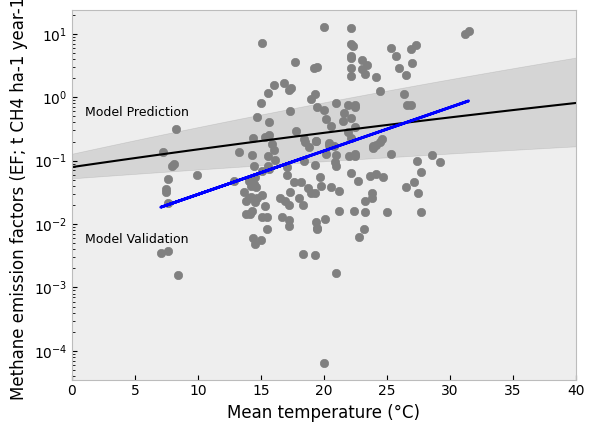

In [31]:
# Plot the data (simpler version)
# Define a color mapping
color_mapping = {'Temperate - cool': 'grey', 'Temperate - warm': 'grey', 'Subtropical': 'grey'}
# Create a new figure
plt.figure(figsize=(6.5, 4.8))

# Plot Tier 3 ribbon
plt.fill_between(TierComp2['Temp'], TierComp2['EF_T3_LCI'], TierComp2['EF_T3_UCI'], alpha=0.1,  color = 'black')

# Plot Tier 3 line
plt.plot(TierComp2['Temp'], TierComp2['EF_T3'], linewidth=1.5, color = 'black')

# Plot farm dam data
for climate in FarmDamData_Aus['Climate.Aus'].unique():
    plt.scatter(FarmDamData_Aus[FarmDamData_Aus['Climate.Aus'] == climate]['Water_Temp_C'], 
                0.00365*FarmDamData_Aus[FarmDamData_Aus['Climate.Aus'] == climate]['CH4_mgm2day.EbuAdj'], 
                label=climate, 
                color=color_mapping[climate])

# Fit a straight line to the log-transformed data
slope, intercept, r_value, p_value, std_err = stats.linregress(FarmDamData_Aus['Water_Temp_C'], np.log10(0.00365*FarmDamData_Aus['CH4_mgm2day.EbuAdj']))
# Calculate the line of fit
line_of_fit = 10**(intercept + slope*FarmDamData_Aus['Water_Temp_C'])
# Plot the line of fit
plt.plot(FarmDamData_Aus['Water_Temp_C'], line_of_fit, 'b')
# Set the scale of the y-axis
plt.yscale('log')
# Set the limits of the x-axis
plt.xlim(0, 40)
# Add label above the black line for Model Prediction
plt.text(1, 10**(-0.3), 'Model Prediction', fontsize=9, color='black', ha='left')
plt.text(1, 10**(-2.3), 'Model Validation', fontsize=9, color='black', ha='left')
# Add labels
plt.xlabel('Mean temperature (°C)')
plt.ylabel('Methane emission factors (EF; t CH4 ha-1 year-1)')
plt.grid(False)
# Add a legend
#plt.legend()
# Save the plot as a PDF file
plt.savefig("Plots/full preds v7/EFtemp.pdf", format='pdf')
# Show the plot
plt.show()

In [32]:
# Define the Boltzmann constant
Boltzmann_const_evK = 8.617333262145*1e-5

# Calculate Boltzmann_15C
FarmDamData_Aus['Boltzmann_15C'] = (1/(Boltzmann_const_evK*(273.15 + 15))) - (1/(Boltzmann_const_evK*(273.15 + FarmDamData_Aus['Water_Temp_C'])))

# Fit the model
Boltzmann_lm = smf.ols(formula='np.log(FarmDamData_Aus["CH4_mgm2day.EbuAdj"]) ~ Boltzmann_15C', data=FarmDamData_Aus).fit()

# Print the summary
print(Boltzmann_lm.summary())
# Print the confidence intervals
print(Boltzmann_lm.conf_int())

                                          OLS Regression Results                                         
Dep. Variable:     np.log(FarmDamData_Aus["CH4_mgm2day.EbuAdj"])   R-squared:                       0.141
Model:                                                       OLS   Adj. R-squared:                  0.136
Method:                                            Least Squares   F-statistic:                     28.67
Date:                                           Wed, 24 Apr 2024   Prob (F-statistic):           2.66e-07
Time:                                                   15:12:56   Log-Likelihood:                -372.01
No. Observations:                                            177   AIC:                             748.0
Df Residuals:                                                175   BIC:                             754.4
Df Model:                                                      1                                         
Covariance Type:                              

In [33]:
# Only for Ollivier
FarmDamData_Oll = FarmDamData_Aus[FarmDamData_Aus['Ref'].isin(['Ollivier', 'Ollivier2'])]
# Ensure no SettingWithCopyWarning to keep original dataframe in memory 
FarmDamData_Oll = FarmDamData_Oll.copy()

# Calculate residuals
FarmDamData_Oll['Res_3'] = np.log10(0.00365 * FarmDamData_Oll['CH4_mgm2day.EbuAdj']) - np.log10(np.exp(0.4287063 * ((1 / (8.617333e-05 * (273.15 + 15))) - (1 / (8.617333e-05 * (273.15 + FarmDamData_Oll['Water_Temp_C'])))) + 5.318143) * 1000 / 1000000)
FarmDamData_Oll['Res_2'] = np.log10(0.00365 * FarmDamData_Oll['CH4_mgm2day.EbuAdj']) - np.log10(0.1518)  # Temperate - cool
FarmDamData_Oll['Res_1'] = np.log10(0.00365 * FarmDamData_Oll['CH4_mgm2day.EbuAdj']) - np.log10(0.228)
FarmDamData_Oll['Res_0'] = np.log10(0.00365 * FarmDamData_Oll['CH4_mgm2day.EbuAdj']) - np.mean(np.log10(0.00365 * FarmDamData_Oll['CH4_mgm2day.EbuAdj']))

# Calculate predictions
FarmDamData_Oll['Pred_3'] = np.log10(np.exp(0.4287063 * ((1 / (8.617333e-05 * (273.15 + 15))) - (1 / (8.617333e-05 * (273.15 + FarmDamData_Oll['Water_Temp_C'])))) + 5.318143) * 1000 / 1000000)
FarmDamData_Oll['Pred_2'] = np.log10(0.1518)  # Temperate - cool
FarmDamData_Oll['Pred_1'] = np.log10(0.228)
FarmDamData_Oll['Pred_0'] = np.mean(np.log10(0.00365 * FarmDamData_Oll['CH4_mgm2day.EbuAdj']))

# Use a LM for comparison
lm_model = smf.ols(formula='np.log10(FarmDamData_Oll["CH4_mgm2day.EbuAdj"]) ~ Water_Temp_C', data=FarmDamData_Oll).fit()
FarmDamData_Oll['Res_Best'] = lm_model.resid
FarmDamData_Oll['Pred_Best'] = lm_model.predict(FarmDamData_Oll[['Water_Temp_C']])

# MAE.Oll_log10_ref
MAE_Oll_log10_ref = {
    'MAE_T1': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T1.kt'])),
    'MAPE_T1': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T1.kt'])) / np.mean(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj'])),
    'MAE_T2': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T2.kt'])),
    'MAPE_T2': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T2.kt'])) / np.mean(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj'])),
    'MAE_T3': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T3.kt'])),
    'MAPE_T3': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T3.kt'])) / np.mean(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']))
}

# MAE.Oll_log10_tot
MAE_Oll_log10_tot = {
    'MAE_T1': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T1.kt'])),
    'MAPE_T1': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T1.kt'])) / np.mean(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj'])),
    'MAE_T2': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T2.kt'])),
    'MAPE_T2': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T2.kt'])) / np.mean(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj'])),
    'MAE_T3': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T3.kt'])),
    'MAPE_T3': mae(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']), np.log10(FarmDamData_Oll['EF_T3.kt'])) / np.mean(np.log10(FarmDamData_Oll['CH4_mgm2day.EbuAdj']))
}

# MAE.Oll_tot
MAE_Oll_tot = {
    'MAE_T1': mae(FarmDamData_Oll['CH4_mgm2day.EbuAdj'], FarmDamData_Oll['EF_T1.kt']),
    'MAPE_T1': mae(FarmDamData_Oll['CH4_mgm2day.EbuAdj'], FarmDamData_Oll['EF_T1.kt']) / np.mean(FarmDamData_Oll['CH4_mgm2day.EbuAdj']),
    'MAE_T2': mae(FarmDamData_Oll['CH4_mgm2day.EbuAdj'], FarmDamData_Oll['EF_T2.kt']),
    'MAPE_T2': mae(FarmDamData_Oll['CH4_mgm2day.EbuAdj'], FarmDamData_Oll['EF_T2.kt']) / np.mean(FarmDamData_Oll['CH4_mgm2day.EbuAdj']),
    'MAE_T3': mae(FarmDamData_Oll['CH4_mgm2day.EbuAdj'], FarmDamData_Oll['EF_T3.kt']),
    'MAPE_T3': mae(FarmDamData_Oll['CH4_mgm2day.EbuAdj'], FarmDamData_Oll['EF_T3.kt']) / np.mean(FarmDamData_Oll['CH4_mgm2day.EbuAdj'])
}

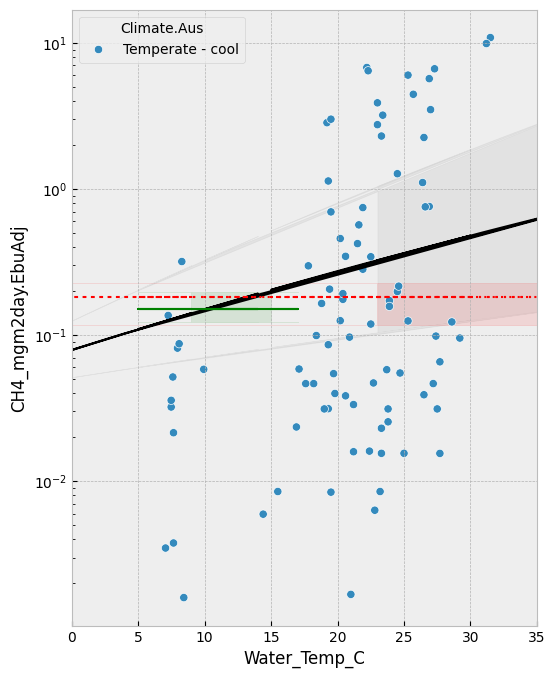

In [35]:
#plot the Data
# Filter data
TierComp2 = TierComp2[TierComp2['Temp'] < 41]
FarmDamData_Oll = FarmDamData_Aus[FarmDamData_Aus['Ref'].isin(['Ollivier', 'Ollivier2'])]

# Create a new figure
plt.figure(figsize=(6, 8))

# Tier 3 ribbon and line
plt.fill_between(TierComp2['Temp'], TierComp2['EF_T3_LCI'], TierComp2['EF_T3_UCI'], color='grey', alpha=.1)
plt.plot(TierComp2['Temp'], TierComp2['EF_T3'], 'k-', linewidth=1.5)
# Tier 1 ribbon and line
plt.fill_between(TierComp2['Temp'], TierComp2['EF_T1_LCI'], TierComp2['EF_T1_UCI'], color='r', alpha=.1)
line, = plt.plot(TierComp2['Temp'], TierComp2['EF_T1'], 'r', linewidth=1.5)  
line.set_dashes([1, 3])  
# Tier 2 ribbon and line
TierComp2_temp_cool = TierComp2[TierComp2['Climate.Aus'] == "Temperate - cool"]
plt.fill_between(TierComp2_temp_cool['Temp'], TierComp2_temp_cool['EF_T2.kt_LCI'], TierComp2_temp_cool['EF_T2.kt_UCI'], color='g', alpha=.1)
plt.plot(TierComp2_temp_cool['Temp'], TierComp2_temp_cool['EF_T2.kt'], 'g-', linewidth=1.5)

# Farm dam data
sns.scatterplot(data=FarmDamData_Oll, x='Water_Temp_C', y= 0.00365*FarmDamData_Oll["CH4_mgm2day.EbuAdj"], hue='Climate.Aus')

# Set y scale to log and limit x axis
plt.yscale('log')
plt.xlim(0, 35)
# Show the plot
plt.show()

In [34]:
## =============
## Test water fluctuations
## =============
# Here we show how much we would overestimate total water if we were to assume always full dams
# load validation data by Nick
ValData = pd.read_csv("Required data/Other datasets/validation_output_WeatherTOWater.csv")

# filter data
ValData = ValData[(ValData['manual_water_area'] > 100) & (ValData['dam_area'] > 100) & (ValData['dam_area'] < 100000)]
# create new columns
ValData['overestimation_m2'] = ValData['dam_area'] - ValData['manual_water_area']
ValData['overestimation_perc'] = ValData['overestimation_m2'] / ValData['dam_area']

ValData['PercFull'] = ValData['manual_water_area']/ValData['dam_area']

# MAE WtW
MAE_WtW = mae(ValData['manual_water_area'], ValData['pred_water_area'])  # m2
# MAPE WtW
MAPE_WtW = MAE_WtW / ValData['manual_water_area'].mean()  # m2
# MAE of assuming max size
MAE_max = mae(ValData['manual_water_area'], ValData['dam_area'])  # m2
# MAPE of assuming max size
MAPE_max = MAE_max / ValData['manual_water_area'].mean()  # m2

SECTION 9

In [35]:
## =============
## 9) ALL STATISTICS
## ============= 
# 6.1 Historical increase in agricultural ponds
# ---
#Calculate relative increase from 1988 to 2020
# Define a function to perform the group calculations
def calculate_metrics(group):
    metrics = {}
    for year in [1990, 2022]:
        year_data = group[group['FinYear'] == year]
        if not year_data.empty:
            metrics[f'Counts_{year}'] = round(year_data['Count.AdjCoef.ecd'].iloc[0], 0)
            metrics[f'SA_{year}'] = round(year_data['SumArea.kha.AdjCoef.ecd'].iloc[0], 2)
            metrics[f'TotE_T3_{year}'] = round(year_data['TotCH4.ktyear.AdjCoef.ecd'].iloc[0], 2)
            metrics[f'Flux_T3_{year}'] = 1000 * round(metrics[f'TotE_T3_{year}'] / metrics[f'SA_{year}'], 3)
    
    # Calculating relative and absolute differences
    for var in ['Counts', 'SA', 'TotE_T3']:
        start_val = metrics.get(f'{var}_1990', 0)
        end_val = metrics.get(f'{var}_2022', 0)
        metrics[f'Rel_{var}_1990to2022'] = "{:.2%}".format((end_val - start_val) / start_val if start_val else 0)
        metrics[f'Abs_{var}_1990to2022'] = round(end_val - start_val, 2)

    # Special case for Flux_T3
    start_val = metrics.get('Flux_T3_1990', 0)
    end_val = metrics.get('Flux_T3_2022', 0)
    metrics['Rel_Flux_T3_1990to2022'] = "{:.2%}".format((end_val - start_val) / start_val if start_val else 0)
    metrics['Abs_Flux_T3_1990to2022'] = round(end_val - start_val, 3)

    return pd.Series(metrics)

# Group by 'NAME' and apply the calculation
Incr1990to2022 = Data9.groupby('NAME').apply(calculate_metrics).reset_index()
# Sorting by absolute counts increase
Incr1990to2022 = Incr1990to2022.sort_values(by='Abs_Counts_1990to2022', ascending=False)

# Save to CSV
Incr1990to2022.to_csv('Tables/Incr1990to2022.csv', index=False)
# Save to a pickle file for Python usage
Incr1990to2022.to_pickle('Tables/Incr1990to2022.pkl')  

# Australia average increase
# Define a function to perform the summarization
def summarize_data(df):
    years = [1990, 2022]
    summary = {}
    for year in years:
        year_data = df[df['FinYear'] == year]
        if not year_data.empty:
            summary[f'Counts_{year}'] = round(year_data['Count.AdjCoef.ecd'].iloc[0], 0)
            summary[f'SA_{year}'] = round(year_data['SumArea.kha.AdjCoef.ecd'].iloc[0], 2)
            summary[f'TotE_T3_{year}'] = round(year_data['TotCH4.ktyear.AdjCoef.ecd'].iloc[0], 2)
            summary[f'Flux_T3_{year}'] = 1000 * round(summary[f'TotE_T3_{year}'] / summary[f'SA_{year}'], 3)
    
    # Calculate relative and absolute changes
    for var in ['Counts', 'SA', 'TotE_T3']:
        start_val = summary.get(f'{var}_1990', 0)
        end_val = summary.get(f'{var}_2022', 0)
        summary[f'Rel_{var}_1990to2022'] = "{:.2%}".format((end_val - start_val) / start_val if start_val else 0)
        summary[f'Abs_{var}_1990to2022'] = round(end_val - start_val, 0)

    # Special case for Flux_T3
    start_val = summary.get('Flux_T3_1990', 0)
    end_val = summary.get('Flux_T3_2022', 0)
    summary['Rel_Flux_T3_1990to2022'] = "{:.2%}".format((end_val - start_val) / start_val if start_val else 0)
    summary['Abs_Flux_T3_1990to2022'] = round(end_val - start_val, 3)

    return pd.Series(summary)

# Apply the summarization function
Incr1990to2022_Aus = summarize_data(Data10)

# Convert the Series to a DataFrame
Incr1990to2022_Aus = Incr1990to2022_Aus.to_frame().T  # Transpose to turn it into a DataFrame

# Save to CSV
Incr1990to2022_Aus.to_csv('Tables/Incr1990to2022.Aus.csv', index=False)
# Save to a pickle file for Python usage
Incr1990to2022_Aus.to_pickle('Tables/Incr1990to2022.Aus.pkl')

C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\3752759361.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [36]:
#6.2 Water surface area of agricultural ponds
# ---
# Calculate relative and absolute year-to-year variability  
# Relative magnitude of year-to-year variability
Data10['SumArea_kha_AdjCoef_ecd_lag'] = Data10['SumArea.kha.AdjCoef.ecd'].shift(1)
Data10['SA_YearToYear_Rel'] = (Data10['SumArea.kha.AdjCoef.ecd'] - Data10['SumArea_kha_AdjCoef_ecd_lag']) / Data10['SumArea_kha_AdjCoef_ecd_lag']
mean_rel_var = 100 * np.mean(np.abs(Data10['SA_YearToYear_Rel'].dropna()))
max_rel_var = 100 * np.max(np.abs(Data10['SA_YearToYear_Rel'].dropna()))
year_of_max_rel_var = Data10.loc[Data10['SA_YearToYear_Rel'].abs().idxmax(), 'FinYear']

# Absolute differences
Data10['SA_YearToYear_Abs'] = np.abs(np.diff(Data10['SumArea.kha.AdjCoef.ecd'], prepend=np.nan))
mean_abs_var = np.mean(Data10['SA_YearToYear_Abs'].dropna())
max_abs_var = np.max(Data10['SA_YearToYear_Abs'].dropna())

# Filter and clean data
RelCapacityBOM_aus_filtered = RelCapacityBOM_aus[RelCapacityBOM_aus['FinYear'] > 1988].dropna(subset=['RelSurfaceArea', 'Anomaly'])
# Calculate Pearson correlation
correlation, p_value = pearsonr(RelCapacityBOM_aus_filtered['RelSurfaceArea'], RelCapacityBOM_aus_filtered['Anomaly'])
print (correlation, p_value)

# Consequences of climate conditions on year-to-year surface area 
# Load the data
Data6_kha_hist = pd.read_csv("Required data/Other datasets/Data6.kha.hist.csv")
# Drop NA values
Data6_kha_hist = Data6_kha_hist.dropna(subset=['FinYear', 'SumArea.kha.Adj.ecd'])
# Calculate differences
Data6_kha_hist['DifSA'] = Data6_kha_hist['SumArea.kha.Adj.ecd'].diff()
Data6_kha_hist['AbsDifSA'] = abs(Data6_kha_hist['DifSA'])
# Summary statistics
summary = Data6_kha_hist['AbsDifSA'].describe()
# Print summary
print(summary)
# Annual estimates of total water surface changed by on average of 14.5 kha (and up to 35.6 kha) due to year-to-year climate conditions.

# Compare surface area and relative capacity between 2016 and 2018/2019 
# Filter data for the years 2016, 2018, and 2019
Data6_kha_hist_2016_2018_2019 = Data6_kha_hist[Data6_kha_hist['FinYear'].isin([2016, 2018, 2019])]
# Select columns
Data6_kha_hist_2016_2018_2019 = Data6_kha_hist[['FinYear', 'SumArea.kha.Adj.ecd']]
# Print the DataFrame
print(Data6_kha_hist_2016_2018_2019)

 # Compare increase since 1990 with 2022 NIR
# Load the NIR 2022 data
NIR2022 = pd.read_csv("Required data/Aus 2022 NIR data.csv")
# Calculate relative increase for NIR 2022
RelIncrease_NIR2022 = (316-275)/275
# Filter data for the years 1990 and 2020
Data6_kha_hist_filtered = Data6_kha_hist[Data6_kha_hist['FinYear'].isin([1990, 2020])]
Data6_kha_hist_filtered = Data6_kha_hist_filtered[['FinYear', 'SumArea.kha.Adj.ecd']]
# Calculate relative increase for NIR 2023
RelIncrease_NIR2023 = (262-179)/179
# Calculate average emission factor for NIR 2022
NIR2022_EF = 1000*40.73/316.36
# Filter data for the year 2020
Data6_kha_hist_2020 = Data6_kha_hist[Data6_kha_hist['FinYear'] == 2020]
Data6_kha_hist_2020  = Data6_kha_hist_2020[['FinYear','TotE_T3.kt.year.Adj.ecd','SumArea.kha.Adj.ecd']]
# Calculate average emission factor for NIR 2023
NIR2023_EF = 1000*61.6/262.

0.5719381524271262 0.00040963813317083453
count    271.000000
mean       3.316857
std        9.059575
min        0.001265
25%        0.142515
50%        1.095793
75%        2.874714
max      107.638005
Name: AbsDifSA, dtype: float64
     FinYear  SumArea.kha.Adj.ecd
7       1988             0.160112
8       1989             0.180816
9       1990             0.224384
10      1991             0.217190
11      1992             0.236916
..       ...                  ...
323     2017            28.359584
324     2018            25.593611
325     2019            23.303743
326     2020            21.719582
327     2021            24.766706

[272 rows x 2 columns]


In [37]:
# 6.3 Methane flux from agricultural ponds
# ---
# What is the range in methane emissions from an average dam at 10C and 30C?
# Filter for temperatures 10 and 30 and select columns
TierComp2_filtered = TierComp2[TierComp2['Temp'].isin([10, 30])]
TierComp2_filtered = TierComp2_filtered[['Temp', 'EF_T3', 'EF_T3_LCI', 'EF_T3_UCI']]
# Print the DataFrame
print(TierComp2_filtered)

# Group by 'Climate' and calculate means
TierComp2_grouped = TierComp2.groupby('Climate').agg({'EF_T2.kt': 'mean', 'EF_T3': 'mean'})
TierComp2_grouped['T2byT3'] = (TierComp2_grouped['EF_T2.kt'] - TierComp2_grouped['EF_T3']) / TierComp2_grouped['EF_T3']

# Sort by 'T2byT3' in descending order
TierComp2_grouped = TierComp2_grouped.sort_values(by='T2byT3', ascending=False)

# Print the DataFrame
print(TierComp2_grouped)

    Temp     EF_T3  EF_T3_LCI  EF_T3_UCI
10    10  0.150395   0.070983   0.330086
11    10  0.150395   0.070983   0.330086
56    30  0.479348   0.126727   1.878217
57    30  0.479348   0.126727   1.878217
                  EF_T2.kt     EF_T3    T2byT3
Climate                                       
Tropical - wet      0.6967  0.398542  0.748120
Subtropical         0.3806  0.286833  0.326903
Tropical - dry      0.5809  0.490903  0.183328
Temperate - warm    0.2376  0.214157  0.109467
Temperate - cool    0.1518  0.163769 -0.073084


C:\Users\oodebiri\AppData\Local\Temp\21\ipykernel_24504\4074785934.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [38]:
# 6.4 Total methane emissions from agricultural ponds in Australia
# ---
# Range and max
# Drop NA values
Summ_Data10 = Data10['TotCH4.ktyear.AdjCoef.ecd'].dropna()
# Range and max
summary = Summ_Data10.describe()
print(summary)

# Rel increase from 1990 to 2022
rel_increase = (Data10.loc[Data10['FinYear'] == 2022, 'TotCH4.ktyear.AdjCoef.ecd'].values[0] - Data10.loc[Data10['FinYear'] == 1990, 'TotCH4.ktyear.AdjCoef.ecd'].values[0]) / Data10.loc[Data10['FinYear'] == 1990, 'TotCH4.ktyear.AdjCoef.ecd'].values[0]
print(rel_increase)

# Trend of increased emissions over time
Trend_Aus = smf.ols(formula='Data10["TotCH4.ktyear.AdjCoef.ecd"] ~ FinYear', data=Data10).fit()
print(Trend_Aus.summary())
print(sm.stats.anova_lm(Trend_Aus, typ=2))

# Year-to-year variability by dividing the st error by the mean
variability = 100 * (0.07359 / 0.33929)
print(variability)

# This increase due to more dams being created? Yes, 16k more dams per year
Trend_Aus_num = smf.ols(formula='Data10["Count.AdjCoef.ecd"] ~ FinYear', data=Data10).fit()
print(Trend_Aus_num.summary())

# What is the effect of new dams on total surface water? 1.26 kha of new surface water per year
Trend_Aus_sw = smf.ols(formula='Data10["SumArea.kha.AdjCoef.ecd"] ~ FinYear', data=Data10).fit()
print(Trend_Aus_sw.summary())

count    33.000000
mean     32.075181
std       5.143848
min      23.256148
25%      27.263201
50%      32.138902
75%      35.476182
max      41.063314
Name: TotCH4.ktyear.AdjCoef.ecd, dtype: float64
0.5780337043736644
                                     OLS Regression Results                                    
Dep. Variable:     Data10["TotCH4.ktyear.AdjCoef.ecd"]   R-squared:                       0.407
Model:                                             OLS   Adj. R-squared:                  0.388
Method:                                  Least Squares   F-statistic:                     21.26
Date:                                 Wed, 24 Apr 2024   Prob (F-statistic):           6.53e-05
Time:                                         15:15:48   Log-Likelihood:                -91.748
No. Observations:                                   33   AIC:                             187.5
Df Residuals:                                       31   BIC:                             190.5
Df Model:    

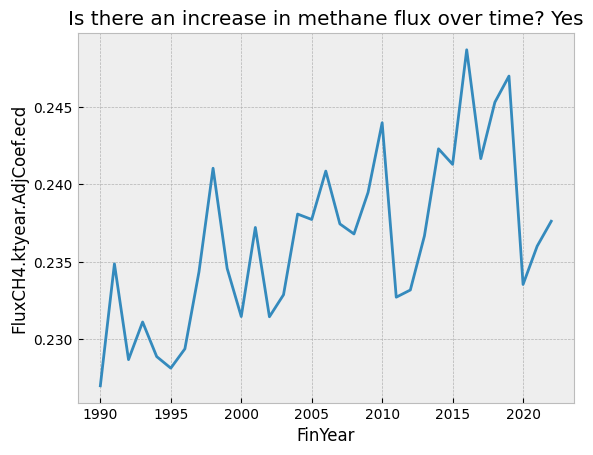

                                     OLS Regression Results                                     
Dep. Variable:     Data10["FluxCH4.ktyear.AdjCoef.ecd"]   R-squared:                       0.437
Model:                                              OLS   Adj. R-squared:                  0.419
Method:                                   Least Squares   F-statistic:                     24.04
Date:                                  Wed, 24 Apr 2024   Prob (F-statistic):           2.83e-05
Time:                                          15:15:59   Log-Likelihood:                 134.37
No. Observations:                                    33   AIC:                            -264.7
Df Residuals:                                        31   BIC:                            -261.8
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

In [39]:
# Is there an increase in methane flux over time? Yes
#plot to see trend and also calculate percentage increae from 1900 t0 2020
plt.plot(Data10['FinYear'], Data10['FluxCH4.ktyear.AdjCoef.ecd'])
plt.xlabel('FinYear')
plt.ylabel('FluxCH4.ktyear.AdjCoef.ecd')
plt.title('Is there an increase in methane flux over time? Yes')
plt.show()

# Fit the model
model = smf.ols(formula='Data10["FluxCH4.ktyear.AdjCoef.ecd"] ~ FinYear', data=Data10)
Trend_Aus_onlyClimate = model.fit()

# Print the summary statistics
print(Trend_Aus_onlyClimate.summary())
# Print the ANOVA table
print(sm.stats.anova_lm(Trend_Aus_onlyClimate, typ=2))
# Predict the values
predictions = Trend_Aus_onlyClimate.predict(Data10['FinYear'])
# Calculate the range of predictions
Range = predictions.min(), predictions.max()
# Calculate the percentage change
pred_range = predictions.max() - predictions.min()
percentage_change = 100 * pred_range / predictions.min()
print('Range of predictions:', Range)
print('Percentage change:', percentage_change)
# Mean methane flux from agricultural ponds has increased by 5.3% from 1990 (0.230) to 2022 (0.242)

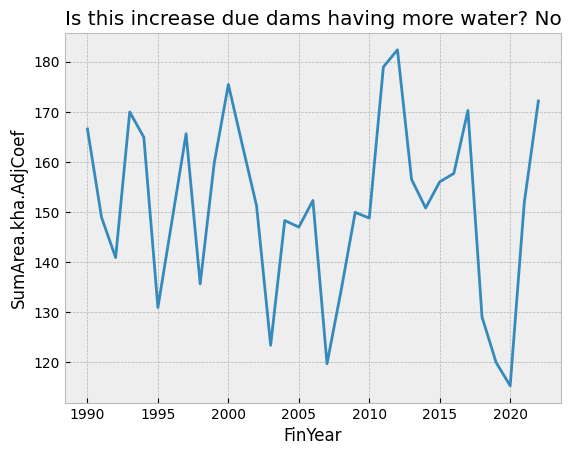

                                  OLS Regression Results                                 
Dep. Variable:     Data10["SumArea.kha.AdjCoef"]   R-squared:                       0.013
Model:                                       OLS   Adj. R-squared:                 -0.019
Method:                            Least Squares   F-statistic:                    0.4180
Date:                           Wed, 24 Apr 2024   Prob (F-statistic):              0.523
Time:                                   15:16:07   Log-Likelihood:                -140.93
No. Observations:                             33   AIC:                             285.9
Df Residuals:                                 31   BIC:                             288.9
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

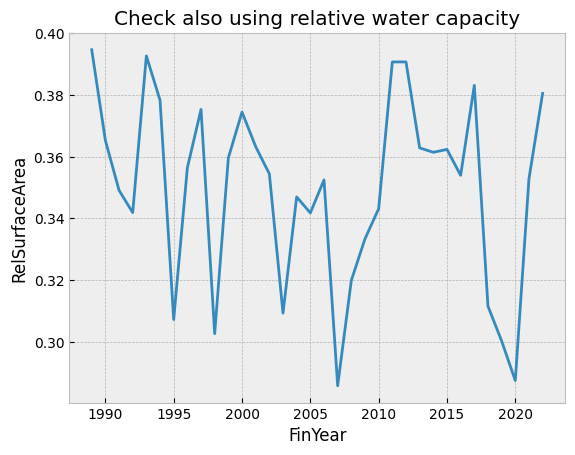

In [40]:
# Is this increase due to dams having more water? No
# Plot area of dams---SumArea.kha.AdjCoef--- over time to see trend
plt.plot(Data10['FinYear'], Data10['SumArea.kha.AdjCoef'])
plt.xlabel('FinYear')
plt.ylabel('SumArea.kha.AdjCoef')
plt.title('Is this increase due dams having more water? No')
plt.show()

# Fit the model
model = smf.ols(formula='Data10["SumArea.kha.AdjCoef"] ~ FinYear', data=Data10)
Trend_Aus_onlyWS = model.fit()

# Print the summary statistics
print(Trend_Aus_onlyWS.summary())

# Print the ANOVA table
print(sm.stats.anova_lm(Trend_Aus_onlyWS, typ=2))

# Plotting RelSurfaceArea over time
plt.plot(RelCapacityBOM_aus['FinYear'], RelCapacityBOM_aus['RelSurfaceArea'])
plt.xlabel('FinYear')
plt.ylabel('RelSurfaceArea')
plt.title('Check also using relative water capacity')
plt.show()

In [41]:
# 6.5 Sensitivity analysis and parameter uncertainty
# ---
# Sensitivity using spider plot using Data_loop2 data
# Methane flux increased by 20%
MetFlux = Data_loop2[Data_loop2['Par'] == "Methane Flux"]
try:
    increase_MetFlux = (MetFlux.loc[MetFlux['Val'] == 1.2, 'TotCH4_ktyear_AdjCoef_ecd'].values[0] - MetFlux.loc[MetFlux['Val'] == 1, 'TotCH4_ktyear_AdjCoef_ecd'].values[0]) / MetFlux.loc[MetFlux['Val'] == 1, 'TotCH4_ktyear_AdjCoef_ecd'].values[0]
except IndexError:
    increase_MetFlux = 0
print(increase_MetFlux)

# Temp sensitivity increased by 20%
TempSens = Data_loop2[Data_loop2['Par'] == "Temp. Sensitivity"]
try:
    increase_TempSens = (TempSens.loc[TempSens['Val'] == 1.2, 'TotCH4_ktyear_AdjCoef_ecd'].values[0] - TempSens.loc[TempSens['Val'] == 1, 'TotCH4_ktyear_AdjCoef_ecd'].values[0]) / TempSens.loc[TempSens['Val'] == 1, 'TotCH4_ktyear_AdjCoef_ecd'].values[0]
except IndexError:
    increase_TempSens = 0
print(increase_TempSens)

# Water surface increased by 20%
WatSur = Data_loop2[Data_loop2['Par'] == "Water Surface"]
try:
    increase_WatSur = (WatSur.loc[WatSur['Val'] == 1.2, 'TotCH4_ktyear_AdjCoef_ecd'].values[0] - WatSur.loc[WatSur['Val'] == 1, 'TotCH4_ktyear_AdjCoef_ecd'].values[0]) / WatSur.loc[WatSur['Val'] == 1, 'TotCH4_ktyear_AdjCoef_ecd'].values[0]
except IndexError:
    increase_WatSur = 0
print(increase_WatSur)

# Parameter uncertainty
AllCV

0
0
0


,labels,CV,CV_std
0,Methane Flux,1.075472,0.538959
1,Temp. Sensitivity,0.499989,0.250563
2,water Surface,0.420000,0.210478
